這邊我會假設你已經看過[Darknet-53_structure](https://github.com/shaoeChen/deeplearning/blob/master/tf2/Arch_YOLOv3_1_Darknet-53_structure.ipynb)、[YOLOv3_structure](https://github.com/shaoeChen/deeplearning/blob/master/tf2/Arch_YOLOv3_2_YOLOv3_structure.ipynb)以及[Arch_YOLOv3_3_loss_function](https://github.com/shaoeChen/deeplearning/blob/master/tf2/Arch_YOLOv3_3_loss_function.ipynb)的說明，而且你也已經完全明白上述三篇文章的說明。

<img src="https://hackmd.io/_uploads/rJ6UBYVli.png" width="75%" />

下面先給出眾多的參考資料，瞭解一個架構不容易，參考的自然也多了，正確的寫出引用、參照是學習過程中的必要：

* [YOLO: Real-Time Object Detection](https://pjreddie.com/darknet/yolo/)
* [pjreddie/darknet](https://github.com/pjreddie/darknet)
* [YOLOv3_論文翻譯連結](https://hackmd.io/@shaoeChen/SyjI6W2zB/https%3A%2F%2Fhackmd.io%2F%40shaoeChen%2FryHg904h9)
* [YOLOv3深度解析](https://blog.csdn.net/leviopku/article/details/82660381)
* [qqwweee/keras-yolo3](https://github.com/qqwweee/keras-yolo3)
* [YunYang1994/tensorflow-yolov3](https://github.com/YunYang1994/tensorflow-yolov3)
* [joymyhome_Yolov3 config file中pad的理解](https://blog.csdn.net/joymyhome/article/details/106349084)
* [華為雲開發者社區](https://segmentfault.com/a/1190000039009074)
* [pylessons_YOLOv3-TF2-mnist](https://pylessons.com/YOLOv3-TF2-mnist)

相關前置資料的處理可以參考另作[Arch_YOLO_dataset_preprocess_2_data_for_yolov3.ipynb](https://github.com/shaoeChen/deeplearning/blob/master/tf2/Arch_YOLO_dataset_preprocess_2_data_for_yolov3.ipynb)

我的docker上執行的版本為tensorflow 2.1，雖然現在流行人生苦短我用PyTorch，不過我還是先繼續tf + keras。

In [1]:
import tensorflow as tf
tf.__version__

'2.1.0'

指定使用的gpu

In [2]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[1], device_type='GPU')

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

我們已經可以成功的從模型中取得粗、中、細的預測資訊，論文中我們知道，每個NxN的grid cell裡面都會有三個預測框的資訊。但不同尺度的預測框大小是不一樣的，這部份是必需要注意的，這從cfg檔中也可以看的出來。

9個框的大小如下：10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326  

粗(13x13)：116,90,  156,198,  373,326  
中(26x26)：30,61,  62,45,  59,119  
細(52x52)：10,13,  16,30,  33,23  

每一組數值代表的就是高跟寬，下面我們也整理一下這九個anchor box

In [4]:
import numpy as np 
# 1.25,1.625, 2.0,3.75, 4.125,2.875, 1.875,3.8125, 3.875,2.8125, 3.6875,7.4375, 3.625,2.8125, 4.875,6.1875, 11.65625,10.1875
# [8, 16, 32]
anchors='10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326'
anchors = [float(x) for x in anchors.split(',')]
anchors = np.array(anchors).reshape((3, 3, 2))
anchors

array([[[ 10.,  13.],
        [ 16.,  30.],
        [ 33.,  23.]],

       [[ 30.,  61.],
        [ 62.,  45.],
        [ 59., 119.]],

       [[116.,  90.],
        [156., 198.],
        [373., 326.]]])

In [5]:
ANCHORS = anchors.copy()

程式碼的部份保證參考[YunYang1994](https://github.com/YunYang1994/TensorFlow2.0-Examples/blob/master/4-Object_Detection/YOLOV3/core/yolov3.py)，只是加入自己的理解說明。

我們已經建構好模型的主幹darknet，也從主幹再延伸出YOLOv3取得它的output，然後也搞定loss function。最後一步就是把這一切拼湊起來訓練。為了版面的整潔，相關程式碼不再貼上，會採用import的方式來取得。手動自己弄個`.py`的文件檔即可，相信不是什麼難事(後續會再另外弄一個專屬於YOLOv3的資料夾)。

載入需求套件

In [6]:
from yolo_utility import yolov3, yolo_loss, bounding_box_iou, bounding_box_giou, decoder

模型不外乎就是input -> output，所以我們先來定義這兩個部份

In [7]:
input_tensor = tf.keras.layers.Input([416, 416, 3])

In [8]:
input_shape = (416, 416, 3)

yolov3_outputs = yolov3(input_tensor)
yolov3_outputs

(<tf.Tensor 'yolo_52x52_7_conv_1/Identity:0' shape=(None, 52, 52, 78) dtype=float32>,
 <tf.Tensor 'yolo_26x26_7_conv_1/Identity:0' shape=(None, 26, 26, 78) dtype=float32>,
 <tf.Tensor 'yolo_13x13_7_conv_1/Identity:0' shape=(None, 13, 13, 78) dtype=float32>)

這時候的yolov3_output裡面包含13x13x255、26x26x255、52x52x255三個不同尺度的輸出，我們就要嚐試利用先前所定義的函數`decoder`來做格式處理。

In [9]:
decoder_output_tensors = []

for i, yolov3_output in enumerate(yolov3_outputs):    
    decoder_tensor = decoder(yolov3_output, 21, i)
    decoder_output_tensors.append(yolov3_output)
    decoder_output_tensors.append(decoder_tensor)

xy_grid: (None, None, None, 3, 2)
xy_grid: (None, None, None, 3, 2)
xy_grid: (None, None, None, 3, 2)


In [10]:
decoder_output_tensors

[<tf.Tensor 'yolo_52x52_7_conv_1/Identity:0' shape=(None, 52, 52, 78) dtype=float32>,
 <tf.Tensor 'concat_2:0' shape=(None, None, None, 3, 26) dtype=float32>,
 <tf.Tensor 'yolo_26x26_7_conv_1/Identity:0' shape=(None, 26, 26, 78) dtype=float32>,
 <tf.Tensor 'concat_5:0' shape=(None, None, None, 3, 26) dtype=float32>,
 <tf.Tensor 'yolo_13x13_7_conv_1/Identity:0' shape=(None, 13, 13, 78) dtype=float32>,
 <tf.Tensor 'concat_8:0' shape=(None, None, None, 3, 26) dtype=float32>]

將這些張量操作也定義進入模型中

In [11]:
model = tf.keras.Model(input_tensor, decoder_output_tensors)

當然如果你願意的話，你也可以將這個模型繪製出來，前提是記得安裝pydot與[graphviz](https://graphviz.org/download/)。這個模型的三個輸出再經過decoder的張量變換操作，基本上非常的大，不過繪製出來看終究是較為清楚的。

In [12]:
# tf.keras.utils.plot_model(model)

別忘了設置優化的方式

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

當然我們並不是因為無聊去把三個輸出轉成這樣子，主要是為了計算loss的格式轉換。在這邊把一些張量流都定義好，理論上應該是會快過過程中去處理才對。

現在我們可以先來取出需求的資料集，這部份可以參考[Arch_YOLO_dataset_preprocess_2_data_for_yolov3.ipynb](https://github.com/shaoeChen/deeplearning/blob/master/tf2/Arch_YOLO_dataset_preprocess_2_data_for_yolov3.ipynb)

一樣的，為了版面清潔，我把整個資料的取得另外包裝一個函數來處理。

In [14]:
import os
from yolo_utility import get_training_data, plot_dataset, generate_data_for_loss

In [15]:
%%time
datasets = get_training_data(5)

(9963, 42, 5)
CPU times: user 3.46 s, sys: 138 ms, total: 3.6 s
Wall time: 3.59 s


我們嚐試列印一張照片出來確認一下，一樣的，相關的函數都在上面dataset_preprocess的裡面有說明。

<Figure size 1152x648 with 0 Axes>

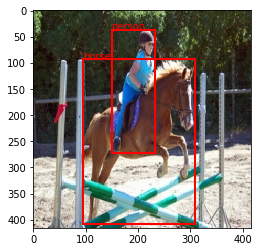

In [16]:
plot_dataset(datasets, 416, 416)

然後利用datasets來生成訓練用的資料，這邊因為我忘記論文中的模型類別數(80)與VOC這資料的類別數(20)不同，有點尷尬，所以這邊的模型還有相關函數的部份還是有做了些許的調整。模型的輸出就變成是M x N x N x (3 * (5 + 21))。

In [17]:
imgs, true_boxes, img_bboxes = generate_data_for_loss(datasets, 5, 42, 21)

一樣的，檢查確認維度是否在預期中

In [18]:
imgs.shape, true_boxes[0].shape, true_boxes[1].shape, true_boxes[2].shape, img_bboxes[0].shape, img_bboxes[1].shape, img_bboxes[2].shape, 

((5, 416, 416, 3),
 (5, 52, 52, 3, 26),
 (5, 26, 26, 3, 26),
 (5, 13, 13, 3, 26),
 (5, 42, 4),
 (5, 42, 4),
 (5, 42, 4))

有照片，有座標，有類別，該有的都有，

模型定義之後就可以來嚐試訓練，一樣的，我們先依序操作一次之後再將整個過程函數化包裝起來。

tf2.0是利用`with tf.GradientTape() as tape`來做為計算梯度的一個context，這部份可以參考簡單[粗暴tensorflow](https://tf.wiki/zh_hant/)，或是在下參考簡單粗暴tensorflow之後自己寫的[ipynb](https://github.com/shaoeChen/deeplearning/blob/master/tf2/MNIST_05_Keras(tf.keras.Model)_GradientTape.ipynb)

In [19]:
def convert_nan2zero(source_tensor):
    """把nan的tensor轉0
    
    如果用nan去跟其它的tensor加總的話會得到nan，因此需要做一個簡單的轉換
    """
    return tf.where(tf.math.is_nan(source_tensor), 0, source_tensor)

In [20]:
with tf.GradientTape() as tape:
    model_output = model(imgs)
    
    # 設置loss的初始值
    giou_loss = conf_loss = prob_loss = 0.
    
    # 接著依各尺度分別計算加總loss
    # 記得我們的輸出分別是raw52, decoder52, raw26, decoder26, raw13, decoder13
    raw52, decoder52, raw26, decoder26, raw13, decoder13 = model_output
    try:
        loss_52 = yolo_loss(decoder52, raw52, true_boxes[0], img_bboxes[0], 21)
        loss_26 = yolo_loss(decoder26, raw26, true_boxes[1], img_bboxes[1], 21)
        loss_13 = yolo_loss(decoder13, raw13, true_boxes[2], img_bboxes[2], 21)
#         import pdb;pdb.set_trace()
    except:
        import pdb;pdb.set_trace()
    
    # loss回傳的順序為giou_loss, conf_loss, prob_loss
    giou_loss = loss_52[0] + loss_26[0] + loss_13[0]
#     conf_loss = loss_52[1] + loss_26[1] + loss_13[1]
    conf_loss = (loss_52[1] / 52.) + (loss_26[1] / 26.) + (loss_13[1] / 13.)
    prob_loss = loss_52[2] + loss_26[2] + loss_13[2]
    
    total_loss = giou_loss + conf_loss + prob_loss
    
    # 計算梯度
    gradients = tape.gradient(total_loss, model.trainable_variables)
#     print(f'gradients: {gradients}')
    # 優化
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))    
    print(f'learning rate: {optimizer.lr.numpy()}, \
            giou_loss: {giou_loss}, include: {loss_52[0]}, {loss_26[0]}, {loss_13[0]}, \
            conf_loss: {conf_loss}, include: {loss_52[1]}, {loss_26[1]}, {loss_13[1]}, \
            prob_loss: {prob_loss}, include: {loss_52[2]}, {loss_26[2]}, {loss_13[2]}, \
            total_loss: {total_loss}')
    

learning rate: 9.999999747378752e-06,             giou_loss: 1.7750247716903687, include: 0.0, 0.821272075176239, 0.9537526965141296,             conf_loss: 47.0647087097168, include: 1405.703125, 351.21771240234375, 84.80656433105469,             prob_loss: 26.200965881347656, include: 0.0, 8.733654975891113, 17.467309951782227,             total_loss: 75.04069519042969


上面來看似乎是沒有問題的，現在，我們就一樣的把這個函數化，準備迴圈訓練看看狀況。

In [21]:
import time
from tqdm import tqdm, trange

In [31]:
def training_step(model, training_data: tuple, epoch: int, loss_list: list, version=False):
    """訓練迭代
    
    model: training model for yolov3
    training_data: (imgs, true_boxes, img_bboxes)
        imgs: 照片
        true_boxes: M x 52 x 52 x ahchor_nums x (5 + class_nums)
                    M x 26 x 26 x ahchor_nums x (5 + class_nums)
                    M x 13 x 13 x ahchor_nums x (5 + class_nums)
                    
        img_bboxes: M x max_bboxes x 4, M x max_bboxes x 4, M x max_bboxes x 4
    epoch: 第幾次迭代
    version: 是否列印訓練訊息
    """        
#     import pdb;pdb.set_trace()
    imgs = training_data[0]
    true_boxes = training_data[1]
    img_bboxes = training_data[2]
    
    with tf.GradientTape() as tape:
        model_output = model(imgs)

        # 設置loss的初始值
        giou_loss = conf_loss = prob_loss = 0.

        # 接著依各尺度分別計算加總loss
        # 記得我們的輸出分別是raw52, decoder52, raw26, decoder26, raw13, decoder13
        raw52, decoder52, raw26, decoder26, raw13, decoder13 = model_output
#         import pdb;pdb.set_trace()
        try:
            loss_52 = yolo_loss(decoder52, raw52, true_boxes[0], img_bboxes[0], 21)
            loss_26 = yolo_loss(decoder26, raw26, true_boxes[1], img_bboxes[1], 21)
            loss_13 = yolo_loss(decoder13, raw13, true_boxes[2], img_bboxes[2], 21)    
        except:
            raise Exception('有毛！')

        # loss回傳的順序為giou_loss, conf_loss, prob_loss
        giou_loss = loss_52[0] + loss_26[0] + loss_13[0]
        conf_loss = (loss_52[1] / 52.) + (loss_26[1] / 26.) + (loss_13[1] / 13.)
        prob_loss = loss_52[2] + loss_26[2] + loss_13[2]

        total_loss = giou_loss + conf_loss + prob_loss
        loss_list.append((giou_loss, conf_loss, prob_loss, total_loss))
        # 計算梯度
        gradients = tape.gradient(total_loss, model.trainable_variables)
        # 優化
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))   
        if version is True and epoch % 100 == 0:
            print(f'learning rate: {optimizer.lr.numpy()}, \
                  giou_loss: {giou_loss}, include: {loss_52[0]}, {loss_26[0]}, {loss_13[0]}, \
                  conf_loss: {conf_loss}, include: {loss_52[1]}, {loss_26[1]}, {loss_13[1]}, \
                  prob_loss: {prob_loss}, include: {loss_52[2]}, {loss_26[2]}, {loss_13[2]}, \
                  total_loss: {total_loss}')
        
        if epoch % 10 == 0 and epoch != 0:
            
            print(f'{time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())}-> training epoch: {epoch}, total loss: {total_loss}')
            

In [26]:
model = tf.keras.Model(input_tensor, decoder_output_tensors)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

在訓練過程中發現，這實在很多毛要注意，一個沒注意，模型的output就通通是nan，不是很好處理。

後來查看有發現到一個問題，模型output nan的問題來自於權重參數通通為nan，而權重參數通通為nan則是來自梯度為nan，再觀察梯度之後發現，梯度他老人家消失了。後來做了幾個模型調整：
1. conf loss做正規化處理，52x52的conf loss就除52，26x26的conf loss就除26，13x13的conf loss就除13
2. conv layer的初始定義修正
3. conv layer的正規化設定
4. 更小的學習效率(0.00001)

基本上一直到更小的學習效率之後整個訓練才有起色，下面模型的訓練是經過七千多次迭代訓練。因為資料有九千多筆，每個批次為五筆，其實一張照片平均來看也不過是過水個兩三次而以。後續再來測試如果單純的以更小的學習效率是否可以成功，以利判斷訓練的成功主要原因是單一的調整因素，還是整體的調整因素所造成的。

In [32]:
epochs = 5000
training_loss = []

for epoch in trange(epochs):
    # 取得一個資料批
    training_data = generate_data_for_loss(datasets, 5, 42, 21)
    training_step(model=model, training_data=training_data, epoch=epoch, loss_list=training_loss, version=True)    

  0%|          | 1/5000 [00:09<13:47:33,  9.93s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 7.978194236755371, include: 1.598457932472229, 2.3202106952667236, 4.059525489807129,                   conf_loss: 0.8036175966262817, include: 9.484782218933105, 5.7199015617370605, 5.215882778167725,                   prob_loss: 11.640509605407715, include: 3.369284152984619, 2.628462314605713, 5.642763137817383,                   total_loss: 20.422321319580078


  0%|          | 11/5000 [01:47<13:28:26,  9.72s/it]

2022-09-22 12:37:00-> training epoch: 10, total loss: 33.9859733581543


  0%|          | 21/5000 [03:26<13:38:04,  9.86s/it]

2022-09-22 12:38:38-> training epoch: 20, total loss: 18.47164535522461


  1%|          | 31/5000 [05:03<13:29:21,  9.77s/it]

2022-09-22 12:40:16-> training epoch: 30, total loss: 31.832275390625


  1%|          | 41/5000 [06:41<13:27:11,  9.77s/it]

2022-09-22 12:41:54-> training epoch: 40, total loss: 45.07081985473633


  1%|          | 51/5000 [08:19<13:24:50,  9.76s/it]

2022-09-22 12:43:32-> training epoch: 50, total loss: 23.568008422851562


  1%|          | 61/5000 [09:57<13:29:54,  9.84s/it]

2022-09-22 12:45:10-> training epoch: 60, total loss: 9.046565055847168


  1%|▏         | 71/5000 [11:35<13:17:00,  9.70s/it]

2022-09-22 12:46:48-> training epoch: 70, total loss: 27.776342391967773


  2%|▏         | 81/5000 [13:13<13:27:19,  9.85s/it]

2022-09-22 12:48:26-> training epoch: 80, total loss: 24.44344711303711


  2%|▏         | 91/5000 [14:51<13:25:39,  9.85s/it]

2022-09-22 12:50:04-> training epoch: 90, total loss: 24.25970458984375


  2%|▏         | 101/5000 [16:29<13:24:28,  9.85s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 15.442214012145996, include: 5.18580436706543, 7.489414215087891, 2.766995668411255,                   conf_loss: 1.3898837566375732, include: 24.729869842529297, 15.350764274597168, 4.210639476776123,                   prob_loss: 20.582534790039062, include: 3.476165771484375, 9.384920120239258, 7.7214484214782715,                   total_loss: 37.414634704589844
2022-09-22 12:51:42-> training epoch: 100, total loss: 37.414634704589844


  2%|▏         | 111/5000 [18:07<13:16:46,  9.78s/it]

2022-09-22 12:53:20-> training epoch: 110, total loss: 14.090073585510254


  2%|▏         | 121/5000 [19:45<13:16:55,  9.80s/it]

2022-09-22 12:54:58-> training epoch: 120, total loss: 18.872493743896484


  3%|▎         | 131/5000 [21:23<13:13:23,  9.78s/it]

2022-09-22 12:56:36-> training epoch: 130, total loss: 25.52725601196289


  3%|▎         | 141/5000 [23:01<13:14:09,  9.81s/it]

2022-09-22 12:58:14-> training epoch: 140, total loss: 25.942140579223633


  3%|▎         | 151/5000 [24:39<13:12:11,  9.80s/it]

2022-09-22 12:59:52-> training epoch: 150, total loss: 11.514310836791992


  3%|▎         | 161/5000 [26:17<13:05:29,  9.74s/it]

2022-09-22 13:01:29-> training epoch: 160, total loss: 43.381378173828125


  3%|▎         | 171/5000 [27:55<13:14:29,  9.87s/it]

2022-09-22 13:03:08-> training epoch: 170, total loss: 30.6925048828125


  4%|▎         | 181/5000 [29:33<13:05:39,  9.78s/it]

2022-09-22 13:04:46-> training epoch: 180, total loss: 15.77963924407959


  4%|▍         | 191/5000 [31:11<12:59:44,  9.73s/it]

2022-09-22 13:06:23-> training epoch: 190, total loss: 12.610774993896484


  4%|▍         | 201/5000 [32:48<13:03:17,  9.79s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 10.625043869018555, include: 1.1945472955703735, 4.6822028160095215, 4.748293399810791,                   conf_loss: 1.0219807624816895, include: 7.070509910583496, 10.146932601928711, 6.4446563720703125,                   prob_loss: 17.985353469848633, include: 2.694550037384033, 6.300743103027344, 8.990060806274414,                   total_loss: 29.63237762451172
2022-09-22 13:08:01-> training epoch: 200, total loss: 29.63237762451172


  4%|▍         | 211/5000 [34:26<13:04:12,  9.83s/it]

2022-09-22 13:09:39-> training epoch: 210, total loss: 22.811691284179688


  4%|▍         | 221/5000 [36:04<13:01:30,  9.81s/it]

2022-09-22 13:11:17-> training epoch: 220, total loss: 22.406232833862305


  5%|▍         | 231/5000 [37:42<13:01:53,  9.84s/it]

2022-09-22 13:12:55-> training epoch: 230, total loss: 11.167421340942383


  5%|▍         | 241/5000 [39:20<13:01:31,  9.85s/it]

2022-09-22 13:14:33-> training epoch: 240, total loss: 23.01274871826172


  5%|▌         | 251/5000 [40:59<13:00:04,  9.86s/it]

2022-09-22 13:16:11-> training epoch: 250, total loss: 21.57720184326172


  5%|▌         | 261/5000 [42:37<12:56:09,  9.83s/it]

2022-09-22 13:17:50-> training epoch: 260, total loss: 9.41701889038086


  5%|▌         | 271/5000 [44:15<12:52:21,  9.80s/it]

2022-09-22 13:19:28-> training epoch: 270, total loss: 15.619327545166016


  6%|▌         | 281/5000 [45:53<12:48:46,  9.77s/it]

2022-09-22 13:21:06-> training epoch: 280, total loss: 10.748489379882812


  6%|▌         | 291/5000 [47:31<12:45:22,  9.75s/it]

2022-09-22 13:22:44-> training epoch: 290, total loss: 10.794225692749023


  6%|▌         | 301/5000 [49:08<12:42:20,  9.73s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 8.256967544555664, include: 0.7983918786048889, 3.881237506866455, 3.5773377418518066,                   conf_loss: 0.7897921204566956, include: 4.851668834686279, 8.974111557006836, 4.567324638366699,                   prob_loss: 15.332159042358398, include: 0.7663605809211731, 6.1206793785095215, 8.44511890411377,                   total_loss: 24.378917694091797
2022-09-22 13:24:21-> training epoch: 300, total loss: 24.378917694091797


  6%|▌         | 311/5000 [50:46<12:44:41,  9.78s/it]

2022-09-22 13:25:59-> training epoch: 310, total loss: 18.643733978271484


  6%|▋         | 321/5000 [52:24<12:38:02,  9.72s/it]

2022-09-22 13:27:37-> training epoch: 320, total loss: 14.764793395996094


  7%|▋         | 331/5000 [54:01<12:42:48,  9.80s/it]

2022-09-22 13:29:14-> training epoch: 330, total loss: 31.9263858795166


  7%|▋         | 341/5000 [55:39<12:39:26,  9.78s/it]

2022-09-22 13:30:52-> training epoch: 340, total loss: 35.213993072509766


  7%|▋         | 351/5000 [57:17<12:38:46,  9.79s/it]

2022-09-22 13:32:30-> training epoch: 350, total loss: 11.48037338256836


  7%|▋         | 361/5000 [58:55<12:37:27,  9.80s/it]

2022-09-22 13:34:08-> training epoch: 360, total loss: 19.222848892211914


  7%|▋         | 371/5000 [1:00:33<12:36:26,  9.80s/it]

2022-09-22 13:35:46-> training epoch: 370, total loss: 18.49666976928711


  8%|▊         | 381/5000 [1:02:10<12:24:45,  9.67s/it]

2022-09-22 13:37:23-> training epoch: 380, total loss: 14.772216796875


  8%|▊         | 391/5000 [1:03:47<12:26:14,  9.71s/it]

2022-09-22 13:39:00-> training epoch: 390, total loss: 22.28545379638672


  8%|▊         | 401/5000 [1:05:25<12:31:59,  9.81s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 5.958507537841797, include: 0.0, 2.702502727508545, 3.256005048751831,                   conf_loss: 0.5734425783157349, include: 0.4019555151462555, 6.6848015785217285, 4.011863708496094,                   prob_loss: 14.613565444946289, include: 0.0, 5.6005778312683105, 9.01298713684082,                   total_loss: 21.14551544189453
2022-09-22 13:40:38-> training epoch: 400, total loss: 21.14551544189453


  8%|▊         | 411/5000 [1:07:04<12:31:11,  9.82s/it]

2022-09-22 13:42:17-> training epoch: 410, total loss: 17.59386444091797


  8%|▊         | 421/5000 [1:08:42<12:27:53,  9.80s/it]

2022-09-22 13:43:54-> training epoch: 420, total loss: 6.810398101806641


  9%|▊         | 431/5000 [1:10:19<12:22:01,  9.74s/it]

2022-09-22 13:45:32-> training epoch: 430, total loss: 18.842409133911133


  9%|▉         | 441/5000 [1:11:56<12:22:16,  9.77s/it]

2022-09-22 13:47:09-> training epoch: 440, total loss: 46.970909118652344


  9%|▉         | 451/5000 [1:13:34<12:18:21,  9.74s/it]

2022-09-22 13:48:47-> training epoch: 450, total loss: 44.73686981201172


  9%|▉         | 461/5000 [1:15:13<12:24:48,  9.85s/it]

2022-09-22 13:50:26-> training epoch: 460, total loss: 25.638181686401367


  9%|▉         | 471/5000 [1:16:51<12:20:29,  9.81s/it]

2022-09-22 13:52:04-> training epoch: 470, total loss: 33.329349517822266


 10%|▉         | 481/5000 [1:18:29<12:14:03,  9.75s/it]

2022-09-22 13:53:42-> training epoch: 480, total loss: 10.680526733398438


 10%|▉         | 491/5000 [1:20:06<12:13:39,  9.76s/it]

2022-09-22 13:55:19-> training epoch: 490, total loss: 9.459774017333984


 10%|█         | 501/5000 [1:21:45<12:22:34,  9.90s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 6.6349992752075195, include: 0.0, 3.141209840774536, 3.4937891960144043,                   conf_loss: 0.7077574729919434, include: 0.41217923164367676, 7.387794494628906, 5.403905391693115,                   prob_loss: 11.705036163330078, include: 0.0, 4.118723392486572, 7.586312770843506,                   total_loss: 19.047792434692383
2022-09-22 13:56:58-> training epoch: 500, total loss: 19.047792434692383


 10%|█         | 511/5000 [1:23:23<12:14:04,  9.81s/it]

2022-09-22 13:58:36-> training epoch: 510, total loss: 13.48476791381836


 10%|█         | 521/5000 [1:25:02<12:14:36,  9.84s/it]

2022-09-22 14:00:15-> training epoch: 520, total loss: 13.456978797912598


 11%|█         | 531/5000 [1:26:40<12:09:14,  9.79s/it]

2022-09-22 14:01:53-> training epoch: 530, total loss: 43.500633239746094


 11%|█         | 541/5000 [1:28:17<12:04:12,  9.74s/it]

2022-09-22 14:03:30-> training epoch: 540, total loss: 34.612579345703125


 11%|█         | 551/5000 [1:29:55<12:06:38,  9.80s/it]

2022-09-22 14:05:08-> training epoch: 550, total loss: 49.182579040527344


 11%|█         | 561/5000 [1:31:32<12:02:39,  9.77s/it]

2022-09-22 14:06:45-> training epoch: 560, total loss: 25.901546478271484


 11%|█▏        | 571/5000 [1:33:10<12:02:36,  9.79s/it]

2022-09-22 14:08:23-> training epoch: 570, total loss: 9.281131744384766


 12%|█▏        | 581/5000 [1:34:48<11:57:25,  9.74s/it]

2022-09-22 14:10:01-> training epoch: 580, total loss: 10.055255889892578


 12%|█▏        | 591/5000 [1:36:26<11:55:01,  9.73s/it]

2022-09-22 14:11:38-> training epoch: 590, total loss: 25.72415542602539


 12%|█▏        | 601/5000 [1:38:03<11:52:57,  9.72s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 1.3874471187591553, include: 0.0, 0.0, 1.3874471187591553,                   conf_loss: 0.23605197668075562, include: 0.3320946991443634, 1.3755491971969604, 2.297877550125122,                   prob_loss: 4.798036098480225, include: 0.0, 0.0, 4.798036098480225,                   total_loss: 6.421535491943359
2022-09-22 14:13:16-> training epoch: 600, total loss: 6.421535491943359


 12%|█▏        | 611/5000 [1:39:41<11:59:31,  9.84s/it]

2022-09-22 14:14:54-> training epoch: 610, total loss: 25.925697326660156


 12%|█▏        | 621/5000 [1:41:19<11:55:32,  9.80s/it]

2022-09-22 14:16:32-> training epoch: 620, total loss: 17.26038932800293


 13%|█▎        | 631/5000 [1:42:57<11:54:43,  9.82s/it]

2022-09-22 14:18:10-> training epoch: 630, total loss: 34.517757415771484


 13%|█▎        | 641/5000 [1:44:35<11:48:37,  9.75s/it]

2022-09-22 14:19:48-> training epoch: 640, total loss: 12.839299201965332


 13%|█▎        | 651/5000 [1:46:13<11:51:01,  9.81s/it]

2022-09-22 14:21:26-> training epoch: 650, total loss: 44.88590621948242


 13%|█▎        | 661/5000 [1:47:51<11:46:56,  9.78s/it]

2022-09-22 14:23:04-> training epoch: 660, total loss: 35.27153778076172


 13%|█▎        | 671/5000 [1:49:29<11:42:36,  9.74s/it]

2022-09-22 14:24:42-> training epoch: 670, total loss: 26.505748748779297


 14%|█▎        | 681/5000 [1:51:06<11:41:43,  9.75s/it]

2022-09-22 14:26:19-> training epoch: 680, total loss: 32.418304443359375


 14%|█▍        | 691/5000 [1:52:44<11:46:22,  9.84s/it]

2022-09-22 14:27:57-> training epoch: 690, total loss: 12.211315155029297


 14%|█▍        | 701/5000 [1:54:23<11:42:38,  9.81s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 3.7347400188446045, include: 0.0, 1.1656384468078613, 2.569101572036743,                   conf_loss: 0.432217001914978, include: 0.3473201394081116, 3.366225481033325, 3.8488783836364746,                   prob_loss: 8.849523544311523, include: 0.0, 2.436363697052002, 6.413159370422363,                   total_loss: 13.016480445861816
2022-09-22 14:29:35-> training epoch: 700, total loss: 13.016480445861816


 14%|█▍        | 711/5000 [1:56:00<11:37:40,  9.76s/it]

2022-09-22 14:31:13-> training epoch: 710, total loss: 18.301198959350586


 14%|█▍        | 721/5000 [1:57:38<11:39:23,  9.81s/it]

2022-09-22 14:32:51-> training epoch: 720, total loss: 17.530000686645508


 15%|█▍        | 731/5000 [1:59:16<11:29:59,  9.70s/it]

2022-09-22 14:34:29-> training epoch: 730, total loss: 15.133710861206055


 15%|█▍        | 741/5000 [2:00:54<11:34:46,  9.79s/it]

2022-09-22 14:36:07-> training epoch: 740, total loss: 11.45529556274414


 15%|█▌        | 751/5000 [2:02:31<11:31:16,  9.76s/it]

2022-09-22 14:37:44-> training epoch: 750, total loss: 41.03208923339844


 15%|█▌        | 761/5000 [2:04:09<11:35:10,  9.84s/it]

2022-09-22 14:39:22-> training epoch: 760, total loss: 9.091573715209961


 15%|█▌        | 771/5000 [2:05:47<11:36:00,  9.87s/it]

2022-09-22 14:41:00-> training epoch: 770, total loss: 28.00299644470215


 16%|█▌        | 781/5000 [2:07:25<11:35:09,  9.89s/it]

2022-09-22 14:42:38-> training epoch: 780, total loss: 27.98129653930664


 16%|█▌        | 791/5000 [2:09:03<11:25:56,  9.78s/it]

2022-09-22 14:44:16-> training epoch: 790, total loss: 13.074479103088379


 16%|█▌        | 801/5000 [2:10:41<11:23:13,  9.76s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 3.74259614944458, include: 0.0, 0.7503551840782166, 2.9922409057617188,                   conf_loss: 0.38252946734428406, include: 0.17386692762374878, 2.2091288566589355, 3.8248519897460938,                   prob_loss: 8.683238983154297, include: 0.0, 1.9407951831817627, 6.742444038391113,                   total_loss: 12.808364868164062
2022-09-22 14:45:53-> training epoch: 800, total loss: 12.808364868164062


 16%|█▌        | 811/5000 [2:12:19<11:21:31,  9.76s/it]

2022-09-22 14:47:31-> training epoch: 810, total loss: 9.24470329284668


 16%|█▋        | 821/5000 [2:13:56<11:19:34,  9.76s/it]

2022-09-22 14:49:09-> training epoch: 820, total loss: 6.396061897277832


 17%|█▋        | 831/5000 [2:15:33<11:13:04,  9.69s/it]

2022-09-22 14:50:46-> training epoch: 830, total loss: 12.914835929870605


 17%|█▋        | 841/5000 [2:17:12<11:15:36,  9.75s/it]

2022-09-22 14:52:24-> training epoch: 840, total loss: 52.71717834472656


 17%|█▋        | 851/5000 [2:18:50<11:18:46,  9.82s/it]

2022-09-22 14:54:03-> training epoch: 850, total loss: 14.242496490478516


 17%|█▋        | 861/5000 [2:20:28<11:17:55,  9.83s/it]

2022-09-22 14:55:41-> training epoch: 860, total loss: 25.657550811767578


 17%|█▋        | 871/5000 [2:22:06<11:13:31,  9.79s/it]

2022-09-22 14:57:19-> training epoch: 870, total loss: 27.953216552734375


 18%|█▊        | 881/5000 [2:23:44<11:09:11,  9.75s/it]

2022-09-22 14:58:57-> training epoch: 880, total loss: 14.844511032104492


 18%|█▊        | 891/5000 [2:25:22<11:10:12,  9.79s/it]

2022-09-22 15:00:35-> training epoch: 890, total loss: 36.084232330322266


 18%|█▊        | 901/5000 [2:27:00<11:08:36,  9.79s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 16.443790435791016, include: 1.9929050207138062, 8.871515274047852, 5.579370498657227,                   conf_loss: 1.1994800567626953, include: 9.482479095458984, 13.803955078125, 6.320643901824951,                   prob_loss: 23.48758888244629, include: 1.4380438327789307, 11.59788703918457, 10.451658248901367,                   total_loss: 41.130859375
2022-09-22 15:02:12-> training epoch: 900, total loss: 41.130859375


 18%|█▊        | 911/5000 [2:28:37<11:04:45,  9.75s/it]

2022-09-22 15:03:50-> training epoch: 910, total loss: 9.788891792297363


 18%|█▊        | 921/5000 [2:30:15<11:06:22,  9.80s/it]

2022-09-22 15:05:28-> training epoch: 920, total loss: 40.550537109375


 19%|█▊        | 931/5000 [2:31:53<11:00:20,  9.74s/it]

2022-09-22 15:07:06-> training epoch: 930, total loss: 20.8406982421875


 19%|█▉        | 941/5000 [2:33:31<11:05:17,  9.83s/it]

2022-09-22 15:08:44-> training epoch: 940, total loss: 24.646839141845703


 19%|█▉        | 951/5000 [2:35:10<11:09:43,  9.92s/it]

2022-09-22 15:10:23-> training epoch: 950, total loss: 12.142487525939941


 19%|█▉        | 961/5000 [2:36:48<11:01:08,  9.82s/it]

2022-09-22 15:12:01-> training epoch: 960, total loss: 23.8492374420166


 19%|█▉        | 971/5000 [2:38:26<10:55:02,  9.75s/it]

2022-09-22 15:13:38-> training epoch: 970, total loss: 32.62193298339844


 20%|█▉        | 981/5000 [2:40:04<10:56:41,  9.80s/it]

2022-09-22 15:15:17-> training epoch: 980, total loss: 24.416929244995117


 20%|█▉        | 991/5000 [2:41:42<10:52:38,  9.77s/it]

2022-09-22 15:16:54-> training epoch: 990, total loss: 24.815528869628906


 20%|██        | 1001/5000 [2:43:19<10:55:33,  9.84s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 7.8583879470825195, include: 1.5962674617767334, 3.4690194129943848, 2.7931010723114014,                   conf_loss: 0.6327848434448242, include: 6.7788825035095215, 6.35912561416626, 3.351919174194336,                   prob_loss: 14.407426834106445, include: 2.0139706134796143, 5.568458557128906, 6.824998378753662,                   total_loss: 22.89859962463379
2022-09-22 15:18:32-> training epoch: 1000, total loss: 22.89859962463379


 20%|██        | 1011/5000 [2:44:57<10:52:21,  9.81s/it]

2022-09-22 15:20:10-> training epoch: 1010, total loss: 9.398468017578125


 20%|██        | 1021/5000 [2:46:35<10:45:23,  9.73s/it]

2022-09-22 15:21:48-> training epoch: 1020, total loss: 19.961475372314453


 21%|██        | 1031/5000 [2:48:13<10:45:04,  9.75s/it]

2022-09-22 15:23:26-> training epoch: 1030, total loss: 25.8261775970459


 21%|██        | 1041/5000 [2:49:51<10:47:53,  9.82s/it]

2022-09-22 15:25:04-> training epoch: 1040, total loss: 25.519874572753906


 21%|██        | 1051/5000 [2:51:29<10:50:45,  9.89s/it]

2022-09-22 15:26:42-> training epoch: 1050, total loss: 23.63338851928711


 21%|██        | 1061/5000 [2:53:06<10:35:29,  9.68s/it]

2022-09-22 15:28:19-> training epoch: 1060, total loss: 16.826231002807617


 21%|██▏       | 1071/5000 [2:54:44<10:37:59,  9.74s/it]

2022-09-22 15:29:57-> training epoch: 1070, total loss: 17.61609649658203


 22%|██▏       | 1081/5000 [2:56:22<10:41:35,  9.82s/it]

2022-09-22 15:31:34-> training epoch: 1080, total loss: 7.866644859313965


 22%|██▏       | 1091/5000 [2:58:00<10:38:24,  9.80s/it]

2022-09-22 15:33:12-> training epoch: 1090, total loss: 26.53278923034668


 22%|██▏       | 1101/5000 [2:59:37<10:34:28,  9.76s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 9.162538528442383, include: 0.3994079828262329, 4.618908882141113, 4.144221305847168,                   conf_loss: 0.7316016554832458, include: 2.180499792098999, 7.889852046966553, 5.02077054977417,                   prob_loss: 13.584360122680664, include: 0.7273335456848145, 5.78554105758667, 7.071485996246338,                   total_loss: 23.478500366210938
2022-09-22 15:34:50-> training epoch: 1100, total loss: 23.478500366210938


 22%|██▏       | 1111/5000 [3:01:15<10:36:36,  9.82s/it]

2022-09-22 15:36:28-> training epoch: 1110, total loss: 13.580327987670898


 22%|██▏       | 1121/5000 [3:02:53<10:30:46,  9.76s/it]

2022-09-22 15:38:06-> training epoch: 1120, total loss: 28.21909523010254


 23%|██▎       | 1131/5000 [3:04:31<10:30:21,  9.78s/it]

2022-09-22 15:39:44-> training epoch: 1130, total loss: 18.527433395385742


 23%|██▎       | 1141/5000 [3:06:09<10:34:16,  9.86s/it]

2022-09-22 15:41:22-> training epoch: 1140, total loss: 16.26512336730957


 23%|██▎       | 1151/5000 [3:07:47<10:31:55,  9.85s/it]

2022-09-22 15:43:00-> training epoch: 1150, total loss: 8.270075798034668


 23%|██▎       | 1161/5000 [3:09:25<10:25:38,  9.78s/it]

2022-09-22 15:44:38-> training epoch: 1160, total loss: 41.000186920166016


 23%|██▎       | 1171/5000 [3:11:03<10:24:42,  9.79s/it]

2022-09-22 15:46:16-> training epoch: 1170, total loss: 18.066171646118164


 24%|██▎       | 1181/5000 [3:12:41<10:24:31,  9.81s/it]

2022-09-22 15:47:54-> training epoch: 1180, total loss: 47.40878677368164


 24%|██▍       | 1191/5000 [3:14:19<10:25:30,  9.85s/it]

2022-09-22 15:49:32-> training epoch: 1190, total loss: 19.781757354736328


 24%|██▍       | 1201/5000 [3:15:57<10:25:38,  9.88s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 4.500980854034424, include: 0.3973155915737152, 2.245711088180542, 1.8579543828964233,                   conf_loss: 0.42032310366630554, include: 1.6849803924560547, 4.121270656585693, 2.9823198318481445,                   prob_loss: 10.181029319763184, include: 0.4456544816493988, 4.2497239112854, 5.485651016235352,                   total_loss: 15.102333068847656
2022-09-22 15:51:10-> training epoch: 1200, total loss: 15.102333068847656


 24%|██▍       | 1211/5000 [3:17:35<10:21:34,  9.84s/it]

2022-09-22 15:52:48-> training epoch: 1210, total loss: 31.1296329498291


 24%|██▍       | 1221/5000 [3:19:13<10:18:00,  9.81s/it]

2022-09-22 15:54:26-> training epoch: 1220, total loss: 24.225587844848633


 25%|██▍       | 1231/5000 [3:20:51<10:17:30,  9.83s/it]

2022-09-22 15:56:04-> training epoch: 1230, total loss: 13.679794311523438


 25%|██▍       | 1241/5000 [3:22:29<10:09:23,  9.73s/it]

2022-09-22 15:57:42-> training epoch: 1240, total loss: 8.195746421813965


 25%|██▌       | 1251/5000 [3:24:07<10:13:38,  9.82s/it]

2022-09-22 15:59:20-> training epoch: 1250, total loss: 9.046996116638184


 25%|██▌       | 1261/5000 [3:25:45<10:10:19,  9.79s/it]

2022-09-22 16:00:58-> training epoch: 1260, total loss: 21.294462203979492


 25%|██▌       | 1271/5000 [3:27:23<10:06:26,  9.76s/it]

2022-09-22 16:02:35-> training epoch: 1270, total loss: 15.095895767211914


 26%|██▌       | 1281/5000 [3:29:01<10:06:32,  9.79s/it]

2022-09-22 16:04:13-> training epoch: 1280, total loss: 20.686450958251953


 26%|██▌       | 1291/5000 [3:30:39<10:08:59,  9.85s/it]

2022-09-22 16:05:52-> training epoch: 1290, total loss: 13.794291496276855


 26%|██▌       | 1301/5000 [3:32:17<10:05:10,  9.82s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 7.501823425292969, include: 0.7985848188400269, 3.4717376232147217, 3.231501340866089,                   conf_loss: 0.5714892148971558, include: 3.1824727058410645, 5.535487174987793, 3.8659980297088623,                   prob_loss: 17.07082748413086, include: 1.215874433517456, 7.4186859130859375, 8.43626594543457,                   total_loss: 25.144140243530273
2022-09-22 16:07:29-> training epoch: 1300, total loss: 25.144140243530273


 26%|██▌       | 1311/5000 [3:33:55<10:06:11,  9.86s/it]

2022-09-22 16:09:07-> training epoch: 1310, total loss: 21.73114013671875


 26%|██▋       | 1321/5000 [3:35:33<10:08:28,  9.92s/it]

2022-09-22 16:10:46-> training epoch: 1320, total loss: 15.3670654296875


 27%|██▋       | 1331/5000 [3:37:11<10:01:21,  9.83s/it]

2022-09-22 16:12:24-> training epoch: 1330, total loss: 17.598827362060547


 27%|██▋       | 1341/5000 [3:38:49<9:51:15,  9.70s/it] 

2022-09-22 16:14:01-> training epoch: 1340, total loss: 26.781431198120117


 27%|██▋       | 1351/5000 [3:40:26<9:53:26,  9.76s/it]

2022-09-22 16:15:39-> training epoch: 1350, total loss: 14.581576347351074


 27%|██▋       | 1361/5000 [3:42:04<9:48:51,  9.71s/it]

2022-09-22 16:17:17-> training epoch: 1360, total loss: 21.22879409790039


 27%|██▋       | 1371/5000 [3:43:41<9:49:54,  9.75s/it]

2022-09-22 16:18:54-> training epoch: 1370, total loss: 13.202953338623047


 28%|██▊       | 1381/5000 [3:45:19<9:48:33,  9.76s/it]

2022-09-22 16:20:32-> training epoch: 1380, total loss: 52.22218322753906


 28%|██▊       | 1391/5000 [3:46:56<9:44:44,  9.72s/it]

2022-09-22 16:22:09-> training epoch: 1390, total loss: 25.344280242919922


 28%|██▊       | 1401/5000 [3:48:34<9:48:51,  9.82s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 4.030368804931641, include: 0.3990779519081116, 1.5599820613861084, 2.0713088512420654,                   conf_loss: 0.37203216552734375, include: 1.6919883489608765, 3.0718398094177246, 2.8775010108947754,                   prob_loss: 9.46154499053955, include: 0.9720673561096191, 3.3001046180725098, 5.189373016357422,                   total_loss: 13.863945960998535
2022-09-22 16:23:47-> training epoch: 1400, total loss: 13.863945960998535


 28%|██▊       | 1411/5000 [3:50:11<9:37:29,  9.65s/it]

2022-09-22 16:25:24-> training epoch: 1410, total loss: 23.319366455078125


 28%|██▊       | 1421/5000 [3:51:49<9:43:32,  9.78s/it]

2022-09-22 16:27:02-> training epoch: 1420, total loss: 18.74722671508789


 29%|██▊       | 1431/5000 [3:53:27<9:45:19,  9.84s/it]

2022-09-22 16:28:40-> training epoch: 1430, total loss: 13.981854438781738


 29%|██▉       | 1441/5000 [3:55:05<9:34:22,  9.68s/it]

2022-09-22 16:30:18-> training epoch: 1440, total loss: 10.355925559997559


 29%|██▉       | 1451/5000 [3:56:44<9:47:32,  9.93s/it]

2022-09-22 16:31:57-> training epoch: 1450, total loss: 11.681563377380371


 29%|██▉       | 1461/5000 [3:58:22<9:40:58,  9.85s/it]

2022-09-22 16:33:35-> training epoch: 1460, total loss: 22.779890060424805


 29%|██▉       | 1471/5000 [3:59:59<9:29:35,  9.68s/it]

2022-09-22 16:35:12-> training epoch: 1470, total loss: 17.098787307739258


 30%|██▉       | 1481/5000 [4:01:38<9:34:43,  9.80s/it]

2022-09-22 16:36:51-> training epoch: 1480, total loss: 26.823486328125


 30%|██▉       | 1491/5000 [4:03:16<9:35:29,  9.84s/it]

2022-09-22 16:38:29-> training epoch: 1490, total loss: 23.656726837158203


 30%|███       | 1501/5000 [4:04:54<9:32:42,  9.82s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 10.723078727722168, include: 1.9872938394546509, 4.665472984313965, 4.070312023162842,                   conf_loss: 0.7850490808486938, include: 6.703344821929932, 8.011616706848145, 4.523993015289307,                   prob_loss: 17.865474700927734, include: 4.440910339355469, 6.9336981773376465, 6.4908647537231445,                   total_loss: 29.37360382080078
2022-09-22 16:40:07-> training epoch: 1500, total loss: 29.37360382080078


 30%|███       | 1511/5000 [4:06:32<9:26:34,  9.74s/it]

2022-09-22 16:41:45-> training epoch: 1510, total loss: 10.361854553222656


 30%|███       | 1521/5000 [4:08:10<9:26:11,  9.76s/it]

2022-09-22 16:43:23-> training epoch: 1520, total loss: 27.667118072509766


 31%|███       | 1531/5000 [4:09:48<9:27:54,  9.82s/it]

2022-09-22 16:45:01-> training epoch: 1530, total loss: 22.73505210876465


 31%|███       | 1541/5000 [4:11:27<9:25:46,  9.81s/it]

2022-09-22 16:46:39-> training epoch: 1540, total loss: 12.545957565307617


 31%|███       | 1551/5000 [4:13:05<9:22:26,  9.78s/it]

2022-09-22 16:48:17-> training epoch: 1550, total loss: 11.654714584350586


 31%|███       | 1561/5000 [4:14:42<9:16:58,  9.72s/it]

2022-09-22 16:49:55-> training epoch: 1560, total loss: 20.489635467529297


 31%|███▏      | 1571/5000 [4:16:20<9:20:12,  9.80s/it]

2022-09-22 16:51:33-> training epoch: 1570, total loss: 23.65502166748047


 32%|███▏      | 1581/5000 [4:17:58<9:19:41,  9.82s/it]

2022-09-22 16:53:11-> training epoch: 1580, total loss: 16.266990661621094


 32%|███▏      | 1591/5000 [4:19:36<9:14:18,  9.76s/it]

2022-09-22 16:54:49-> training epoch: 1590, total loss: 16.09918212890625


 32%|███▏      | 1601/5000 [4:21:14<9:16:04,  9.82s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 1.3238162994384766, include: 0.0, 0.3806670308113098, 0.943149209022522,                   conf_loss: 0.2463584840297699, include: 0.3444617688655853, 1.399045467376709, 2.417022228240967,                   prob_loss: 4.499284744262695, include: 0.0, 0.8927209973335266, 3.6065635681152344,                   total_loss: 6.069459438323975
2022-09-22 16:56:27-> training epoch: 1600, total loss: 6.069459438323975


 32%|███▏      | 1611/5000 [4:22:52<9:10:50,  9.75s/it]

2022-09-22 16:58:04-> training epoch: 1610, total loss: 20.518688201904297


 32%|███▏      | 1621/5000 [4:24:30<9:12:12,  9.81s/it]

2022-09-22 16:59:42-> training epoch: 1620, total loss: 11.839223861694336


 33%|███▎      | 1631/5000 [4:26:08<9:13:30,  9.86s/it]

2022-09-22 17:01:21-> training epoch: 1630, total loss: 26.279361724853516


 33%|███▎      | 1641/5000 [4:27:46<9:09:17,  9.81s/it]

2022-09-22 17:02:59-> training epoch: 1640, total loss: 11.813846588134766


 33%|███▎      | 1651/5000 [4:29:24<9:08:02,  9.82s/it]

2022-09-22 17:04:37-> training epoch: 1650, total loss: 27.72125244140625


 33%|███▎      | 1661/5000 [4:31:01<8:58:01,  9.67s/it]

2022-09-22 17:06:14-> training epoch: 1660, total loss: 11.511438369750977


 33%|███▎      | 1671/5000 [4:32:40<9:05:18,  9.83s/it]

2022-09-22 17:07:53-> training epoch: 1670, total loss: 26.515750885009766


 34%|███▎      | 1681/5000 [4:34:18<9:01:23,  9.79s/it]

2022-09-22 17:09:30-> training epoch: 1680, total loss: 27.554677963256836


 34%|███▍      | 1691/5000 [4:35:56<9:06:20,  9.91s/it]

2022-09-22 17:11:09-> training epoch: 1690, total loss: 10.115894317626953


 34%|███▍      | 1701/5000 [4:37:35<8:59:58,  9.82s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 3.278712749481201, include: 0.0, 0.7505298852920532, 2.5281829833984375,                   conf_loss: 0.336570680141449, include: 0.2426104098558426, 1.8059971332550049, 3.4117674827575684,                   prob_loss: 10.505427360534668, include: 0.0, 1.333431601524353, 9.171996116638184,                   total_loss: 14.120710372924805
2022-09-22 17:12:47-> training epoch: 1700, total loss: 14.120710372924805


 34%|███▍      | 1711/5000 [4:39:13<8:56:27,  9.79s/it]

2022-09-22 17:14:26-> training epoch: 1710, total loss: 18.962284088134766


 34%|███▍      | 1721/5000 [4:40:51<8:53:23,  9.76s/it]

2022-09-22 17:16:03-> training epoch: 1720, total loss: 18.093841552734375


 35%|███▍      | 1731/5000 [4:42:29<8:55:03,  9.82s/it]

2022-09-22 17:17:42-> training epoch: 1730, total loss: 20.91459846496582


 35%|███▍      | 1741/5000 [4:44:07<8:52:15,  9.80s/it]

2022-09-22 17:19:20-> training epoch: 1740, total loss: 40.193809509277344


 35%|███▌      | 1751/5000 [4:45:45<8:53:39,  9.86s/it]

2022-09-22 17:20:58-> training epoch: 1750, total loss: 11.159673690795898


 35%|███▌      | 1761/5000 [4:47:24<8:49:56,  9.82s/it]

2022-09-22 17:22:37-> training epoch: 1760, total loss: 23.24091339111328


 35%|███▌      | 1771/5000 [4:49:02<8:48:38,  9.82s/it]

2022-09-22 17:24:15-> training epoch: 1770, total loss: 20.83454704284668


 36%|███▌      | 1781/5000 [4:50:40<8:48:25,  9.85s/it]

2022-09-22 17:25:53-> training epoch: 1780, total loss: 30.79042625427246


 36%|███▌      | 1791/5000 [4:52:18<8:44:53,  9.81s/it]

2022-09-22 17:27:31-> training epoch: 1790, total loss: 28.127052307128906


 36%|███▌      | 1801/5000 [4:53:56<8:40:05,  9.75s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 2.7754058837890625, include: 0.3981049656867981, 0.8051328659057617, 1.572167992591858,                   conf_loss: 0.3534994125366211, include: 1.784867286682129, 2.4680182933807373, 2.915266513824463,                   prob_loss: 6.5844831466674805, include: 0.8916536569595337, 1.346716284751892, 4.346113204956055,                   total_loss: 9.713388442993164
2022-09-22 17:29:09-> training epoch: 1800, total loss: 9.713388442993164


 36%|███▌      | 1811/5000 [4:55:33<8:37:05,  9.73s/it]

2022-09-22 17:30:46-> training epoch: 1810, total loss: 12.8671236038208


 36%|███▋      | 1821/5000 [4:57:11<8:37:46,  9.77s/it]

2022-09-22 17:32:24-> training epoch: 1820, total loss: 25.71859359741211


 37%|███▋      | 1831/5000 [4:58:49<8:34:22,  9.74s/it]

2022-09-22 17:34:02-> training epoch: 1830, total loss: 28.259521484375


 37%|███▋      | 1841/5000 [5:00:27<8:33:16,  9.75s/it]

2022-09-22 17:35:40-> training epoch: 1840, total loss: 14.310604095458984


 37%|███▋      | 1851/5000 [5:02:05<8:37:31,  9.86s/it]

2022-09-22 17:37:18-> training epoch: 1850, total loss: 17.331287384033203


 37%|███▋      | 1861/5000 [5:03:43<8:30:21,  9.76s/it]

2022-09-22 17:38:55-> training epoch: 1860, total loss: 24.457658767700195


 37%|███▋      | 1871/5000 [5:05:20<8:29:12,  9.76s/it]

2022-09-22 17:40:33-> training epoch: 1870, total loss: 11.602004051208496


 38%|███▊      | 1881/5000 [5:06:59<8:33:50,  9.88s/it]

2022-09-22 17:42:12-> training epoch: 1880, total loss: 25.49725341796875


 38%|███▊      | 1891/5000 [5:08:36<8:26:05,  9.77s/it]

2022-09-22 17:43:49-> training epoch: 1890, total loss: 19.115734100341797


 38%|███▊      | 1901/5000 [5:10:15<8:29:19,  9.86s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 3.1214981079101562, include: 0.3982318043708801, 1.1541956663131714, 1.56907057762146,                   conf_loss: 0.34574756026268005, include: 1.907482385635376, 2.677371025085449, 2.6791622638702393,                   prob_loss: 8.655484199523926, include: 1.234081745147705, 2.7033019065856934, 4.718100547790527,                   total_loss: 12.122730255126953
2022-09-22 17:45:28-> training epoch: 1900, total loss: 12.122730255126953


 38%|███▊      | 1911/5000 [5:11:53<8:25:20,  9.82s/it]

2022-09-22 17:47:06-> training epoch: 1910, total loss: 34.123966217041016


 38%|███▊      | 1921/5000 [5:13:31<8:24:47,  9.84s/it]

2022-09-22 17:48:44-> training epoch: 1920, total loss: 9.581963539123535


 39%|███▊      | 1931/5000 [5:15:09<8:22:00,  9.81s/it]

2022-09-22 17:50:22-> training epoch: 1930, total loss: 27.72564125061035


 39%|███▉      | 1941/5000 [5:16:47<8:18:07,  9.77s/it]

2022-09-22 17:52:00-> training epoch: 1940, total loss: 11.387792587280273


 39%|███▉      | 1951/5000 [5:18:26<8:16:55,  9.78s/it]

2022-09-22 17:53:39-> training epoch: 1950, total loss: 13.061610221862793


 39%|███▉      | 1961/5000 [5:20:04<8:20:39,  9.88s/it]

2022-09-22 17:55:17-> training epoch: 1960, total loss: 42.6194953918457


 39%|███▉      | 1971/5000 [5:21:42<8:18:51,  9.88s/it]

2022-09-22 17:56:55-> training epoch: 1970, total loss: 13.997638702392578


 40%|███▉      | 1981/5000 [5:23:20<8:14:08,  9.82s/it]

2022-09-22 17:58:33-> training epoch: 1980, total loss: 34.439674377441406


 40%|███▉      | 1991/5000 [5:24:58<8:10:43,  9.79s/it]

2022-09-22 18:00:11-> training epoch: 1990, total loss: 15.174013137817383


 40%|████      | 2001/5000 [5:26:37<8:14:35,  9.90s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 4.266377925872803, include: 0.3980255424976349, 0.7573145627975464, 3.1110379695892334,                   conf_loss: 0.48012372851371765, include: 2.0044267177581787, 2.9586310386657715, 4.261186122894287,                   prob_loss: 7.460545539855957, include: 0.481689453125, 0.9679527282714844, 6.010903358459473,                   total_loss: 12.207046508789062
2022-09-22 18:01:50-> training epoch: 2000, total loss: 12.207046508789062


 40%|████      | 2011/5000 [5:28:15<8:09:18,  9.82s/it]

2022-09-22 18:03:28-> training epoch: 2010, total loss: 23.57662582397461


 40%|████      | 2021/5000 [5:29:53<8:05:19,  9.77s/it]

2022-09-22 18:05:06-> training epoch: 2020, total loss: 34.046146392822266


 41%|████      | 2031/5000 [5:31:31<8:03:35,  9.77s/it]

2022-09-22 18:06:43-> training epoch: 2030, total loss: 7.25542688369751


 41%|████      | 2041/5000 [5:33:09<8:03:32,  9.80s/it]

2022-09-22 18:08:22-> training epoch: 2040, total loss: 14.140558242797852


 41%|████      | 2051/5000 [5:34:47<7:59:42,  9.76s/it]

2022-09-22 18:09:59-> training epoch: 2050, total loss: 37.66582107543945


 41%|████      | 2061/5000 [5:36:25<7:59:28,  9.79s/it]

2022-09-22 18:11:38-> training epoch: 2060, total loss: 10.195704460144043


 41%|████▏     | 2071/5000 [5:38:03<7:59:58,  9.83s/it]

2022-09-22 18:13:16-> training epoch: 2070, total loss: 20.003578186035156


 42%|████▏     | 2081/5000 [5:39:40<7:49:05,  9.64s/it]

2022-09-22 18:14:53-> training epoch: 2080, total loss: 35.132102966308594


 42%|████▏     | 2091/5000 [5:41:18<7:57:59,  9.86s/it]

2022-09-22 18:16:31-> training epoch: 2090, total loss: 15.091972351074219


 42%|████▏     | 2101/5000 [5:42:57<7:57:53,  9.89s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 3.686969518661499, include: 0.39842522144317627, 0.781894862651825, 2.5066494941711426,                   conf_loss: 0.36869609355926514, include: 1.7735834121704102, 2.0252315998077393, 3.3370373249053955,                   prob_loss: 6.6472039222717285, include: 0.42155951261520386, 1.0292075872421265, 5.196436882019043,                   total_loss: 10.702869415283203
2022-09-22 18:18:10-> training epoch: 2100, total loss: 10.702869415283203


 42%|████▏     | 2111/5000 [5:44:35<7:55:22,  9.87s/it]

2022-09-22 18:19:48-> training epoch: 2110, total loss: 10.95110034942627


 42%|████▏     | 2121/5000 [5:46:12<7:46:53,  9.73s/it]

2022-09-22 18:21:25-> training epoch: 2120, total loss: 51.92699432373047


 43%|████▎     | 2131/5000 [5:47:50<7:48:12,  9.79s/it]

2022-09-22 18:23:03-> training epoch: 2130, total loss: 18.35367774963379


 43%|████▎     | 2141/5000 [5:49:28<7:47:18,  9.81s/it]

2022-09-22 18:24:41-> training epoch: 2140, total loss: 28.049274444580078


 43%|████▎     | 2151/5000 [5:51:06<7:47:26,  9.84s/it]

2022-09-22 18:26:18-> training epoch: 2150, total loss: 29.266342163085938


 43%|████▎     | 2161/5000 [5:52:44<7:45:06,  9.83s/it]

2022-09-22 18:27:57-> training epoch: 2160, total loss: 16.266416549682617


 43%|████▎     | 2171/5000 [5:54:22<7:40:48,  9.77s/it]

2022-09-22 18:29:35-> training epoch: 2170, total loss: 26.295578002929688


 44%|████▎     | 2181/5000 [5:56:00<7:37:32,  9.74s/it]

2022-09-22 18:31:13-> training epoch: 2180, total loss: 11.58476734161377


 44%|████▍     | 2191/5000 [5:57:39<7:41:28,  9.86s/it]

2022-09-22 18:32:51-> training epoch: 2190, total loss: 36.472190856933594


 44%|████▍     | 2201/5000 [5:59:16<7:35:42,  9.77s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 10.122169494628906, include: 0.7977021932601929, 4.210459232330322, 5.11400842666626,                   conf_loss: 0.7328270077705383, include: 2.727773666381836, 6.775830268859863, 5.456892490386963,                   prob_loss: 19.40557098388672, include: 0.7211861610412598, 7.133273124694824, 11.551111221313477,                   total_loss: 30.26056671142578
2022-09-22 18:34:29-> training epoch: 2200, total loss: 30.26056671142578


 44%|████▍     | 2211/5000 [6:00:54<7:36:22,  9.82s/it]

2022-09-22 18:36:07-> training epoch: 2210, total loss: 9.054191589355469


 44%|████▍     | 2221/5000 [6:02:33<7:34:00,  9.80s/it]

2022-09-22 18:37:46-> training epoch: 2220, total loss: 19.023651123046875


 45%|████▍     | 2231/5000 [6:04:11<7:33:34,  9.83s/it]

2022-09-22 18:39:24-> training epoch: 2230, total loss: 10.089524269104004


 45%|████▍     | 2241/5000 [6:05:49<7:31:23,  9.82s/it]

2022-09-22 18:41:02-> training epoch: 2240, total loss: 76.95030975341797


 45%|████▌     | 2251/5000 [6:07:27<7:26:45,  9.75s/it]

2022-09-22 18:42:40-> training epoch: 2250, total loss: 10.891074180603027


 45%|████▌     | 2261/5000 [6:09:05<7:28:45,  9.83s/it]

2022-09-22 18:44:18-> training epoch: 2260, total loss: 19.742019653320312


 45%|████▌     | 2271/5000 [6:10:43<7:25:24,  9.79s/it]

2022-09-22 18:45:56-> training epoch: 2270, total loss: 22.314226150512695


 46%|████▌     | 2281/5000 [6:12:22<7:27:44,  9.88s/it]

2022-09-22 18:47:34-> training epoch: 2280, total loss: 20.132003784179688


 46%|████▌     | 2291/5000 [6:14:00<7:24:04,  9.84s/it]

2022-09-22 18:49:12-> training epoch: 2290, total loss: 17.067916870117188


 46%|████▌     | 2301/5000 [6:15:37<7:14:57,  9.67s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 7.82237434387207, include: 1.9914348125457764, 4.574429988861084, 1.256509780883789,                   conf_loss: 0.5426649451255798, include: 5.724225044250488, 6.60577392578125, 2.3207011222839355,                   prob_loss: 16.961475372314453, include: 4.802710056304932, 8.014959335327148, 4.143805980682373,                   total_loss: 25.326515197753906
2022-09-22 18:50:50-> training epoch: 2300, total loss: 25.326515197753906


 46%|████▌     | 2311/5000 [6:17:15<7:19:54,  9.82s/it]

2022-09-22 18:52:28-> training epoch: 2310, total loss: 9.46963882446289


 46%|████▋     | 2321/5000 [6:18:53<7:14:52,  9.74s/it]

2022-09-22 18:54:06-> training epoch: 2320, total loss: 31.664127349853516


 47%|████▋     | 2331/5000 [6:20:31<7:12:58,  9.73s/it]

2022-09-22 18:55:43-> training epoch: 2330, total loss: 14.508000373840332


 47%|████▋     | 2341/5000 [6:22:09<7:11:37,  9.74s/it]

2022-09-22 18:57:21-> training epoch: 2340, total loss: 22.701107025146484


 47%|████▋     | 2351/5000 [6:23:46<7:11:40,  9.78s/it]

2022-09-22 18:58:59-> training epoch: 2350, total loss: 25.775312423706055


 47%|████▋     | 2361/5000 [6:25:24<7:10:45,  9.79s/it]

2022-09-22 19:00:37-> training epoch: 2360, total loss: 17.29193115234375


 47%|████▋     | 2371/5000 [6:27:02<7:06:34,  9.74s/it]

2022-09-22 19:02:14-> training epoch: 2370, total loss: 33.06593322753906


 48%|████▊     | 2381/5000 [6:28:40<7:10:48,  9.87s/it]

2022-09-22 19:03:53-> training epoch: 2380, total loss: 16.193063735961914


 48%|████▊     | 2391/5000 [6:30:18<7:05:07,  9.78s/it]

2022-09-22 19:05:31-> training epoch: 2390, total loss: 15.36001205444336


 48%|████▊     | 2401/5000 [6:31:55<7:04:24,  9.80s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 1.7819006443023682, include: 0.0, 0.35152119398117065, 1.4303795099258423,                   conf_loss: 0.2293362021446228, include: 0.4801402688026428, 1.142042875289917, 2.290314197540283,                   prob_loss: 6.024318218231201, include: 0.0, 1.0830198526382446, 4.941298484802246,                   total_loss: 8.035554885864258
2022-09-22 19:07:08-> training epoch: 2400, total loss: 8.035554885864258


 48%|████▊     | 2411/5000 [6:33:34<7:06:21,  9.88s/it]

2022-09-22 19:08:46-> training epoch: 2410, total loss: 13.587273597717285


 48%|████▊     | 2421/5000 [6:35:11<6:56:33,  9.69s/it]

2022-09-22 19:10:24-> training epoch: 2420, total loss: 17.00052261352539


 49%|████▊     | 2431/5000 [6:36:49<7:02:43,  9.87s/it]

2022-09-22 19:12:02-> training epoch: 2430, total loss: 36.37302780151367


 49%|████▉     | 2441/5000 [6:38:28<6:57:46,  9.80s/it]

2022-09-22 19:13:41-> training epoch: 2440, total loss: 13.630903244018555


 49%|████▉     | 2451/5000 [6:40:06<6:57:12,  9.82s/it]

2022-09-22 19:15:19-> training epoch: 2450, total loss: 11.867417335510254


 49%|████▉     | 2461/5000 [6:41:44<6:55:34,  9.82s/it]

2022-09-22 19:16:57-> training epoch: 2460, total loss: 10.137589454650879


 49%|████▉     | 2471/5000 [6:43:23<6:55:09,  9.85s/it]

2022-09-22 19:18:35-> training epoch: 2470, total loss: 19.350393295288086


 50%|████▉     | 2481/5000 [6:45:00<6:49:00,  9.74s/it]

2022-09-22 19:20:13-> training epoch: 2480, total loss: 13.985390663146973


 50%|████▉     | 2491/5000 [6:46:38<6:46:39,  9.72s/it]

2022-09-22 19:21:51-> training epoch: 2490, total loss: 16.094772338867188


 50%|█████     | 2501/5000 [6:48:16<6:48:32,  9.81s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 30.667530059814453, include: 5.580323696136475, 15.5066499710083, 9.580556869506836,                   conf_loss: 1.81454336643219, include: 15.293577194213867, 20.661760330200195, 9.434788703918457,                   prob_loss: 54.64662170410156, include: 10.603845596313477, 27.1063289642334, 16.93644905090332,                   total_loss: 87.12869262695312
2022-09-22 19:23:29-> training epoch: 2500, total loss: 87.12869262695312


 50%|█████     | 2511/5000 [6:49:54<6:46:40,  9.80s/it]

2022-09-22 19:25:07-> training epoch: 2510, total loss: 10.550164222717285


 50%|█████     | 2521/5000 [6:51:32<6:44:35,  9.79s/it]

2022-09-22 19:26:45-> training epoch: 2520, total loss: 29.982830047607422


 51%|█████     | 2531/5000 [6:53:10<6:45:08,  9.85s/it]

2022-09-22 19:28:23-> training epoch: 2530, total loss: 9.08565616607666


 51%|█████     | 2541/5000 [6:54:48<6:44:23,  9.87s/it]

2022-09-22 19:30:01-> training epoch: 2540, total loss: 16.678668975830078


 51%|█████     | 2551/5000 [6:56:26<6:39:00,  9.78s/it]

2022-09-22 19:31:39-> training epoch: 2550, total loss: 20.47214126586914


 51%|█████     | 2561/5000 [6:58:04<6:37:57,  9.79s/it]

2022-09-22 19:33:17-> training epoch: 2560, total loss: 15.08884048461914


 51%|█████▏    | 2571/5000 [6:59:42<6:39:55,  9.88s/it]

2022-09-22 19:34:55-> training epoch: 2570, total loss: 23.79686737060547


 52%|█████▏    | 2581/5000 [7:01:20<6:32:14,  9.73s/it]

2022-09-22 19:36:32-> training epoch: 2580, total loss: 20.356815338134766


 52%|█████▏    | 2591/5000 [7:02:58<6:34:33,  9.83s/it]

2022-09-22 19:38:11-> training epoch: 2590, total loss: 22.363327026367188


 52%|█████▏    | 2601/5000 [7:04:37<6:34:49,  9.87s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 1.5824038982391357, include: 0.0, 0.0, 1.5824038982391357,                   conf_loss: 0.294300377368927, include: 0.6646344065666199, 0.9781746864318848, 3.170659065246582,                   prob_loss: 4.869808673858643, include: 0.0, 0.0, 4.869808673858643,                   total_loss: 6.7465128898620605
2022-09-22 19:39:49-> training epoch: 2600, total loss: 6.7465128898620605


 52%|█████▏    | 2611/5000 [7:06:14<6:24:24,  9.65s/it]

2022-09-22 19:41:27-> training epoch: 2610, total loss: 6.526220321655273


 52%|█████▏    | 2621/5000 [7:07:52<6:26:00,  9.74s/it]

2022-09-22 19:43:05-> training epoch: 2620, total loss: 11.1690673828125


 53%|█████▎    | 2631/5000 [7:09:30<6:27:39,  9.82s/it]

2022-09-22 19:44:42-> training epoch: 2630, total loss: 42.433536529541016


 53%|█████▎    | 2641/5000 [7:11:08<6:25:19,  9.80s/it]

2022-09-22 19:46:21-> training epoch: 2640, total loss: 29.285114288330078


 53%|█████▎    | 2651/5000 [7:12:46<6:24:11,  9.81s/it]

2022-09-22 19:47:59-> training epoch: 2650, total loss: 19.772594451904297


 53%|█████▎    | 2661/5000 [7:14:23<6:16:01,  9.65s/it]

2022-09-22 19:49:36-> training epoch: 2660, total loss: 22.026718139648438


 53%|█████▎    | 2671/5000 [7:16:00<6:15:37,  9.68s/it]

2022-09-22 19:51:13-> training epoch: 2670, total loss: 15.76414966583252


 54%|█████▎    | 2681/5000 [7:17:37<6:15:47,  9.72s/it]

2022-09-22 19:52:50-> training epoch: 2680, total loss: 16.806730270385742


 54%|█████▍    | 2691/5000 [7:19:15<6:14:31,  9.73s/it]

2022-09-22 19:54:27-> training epoch: 2690, total loss: 44.35643768310547


 54%|█████▍    | 2701/5000 [7:20:53<6:16:23,  9.82s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 6.148486614227295, include: 0.0, 2.5429511070251465, 3.6055355072021484,                   conf_loss: 0.4666946828365326, include: 0.8193601369857788, 3.7161097526550293, 4.004136085510254,                   prob_loss: 12.137177467346191, include: 0.0, 5.090892314910889, 7.046285152435303,                   total_loss: 18.75235939025879
2022-09-22 19:56:06-> training epoch: 2700, total loss: 18.75235939025879


 54%|█████▍    | 2711/5000 [7:22:31<6:15:34,  9.84s/it]

2022-09-22 19:57:44-> training epoch: 2710, total loss: 23.565410614013672


 54%|█████▍    | 2721/5000 [7:24:09<6:12:30,  9.81s/it]

2022-09-22 19:59:21-> training epoch: 2720, total loss: 18.080915451049805


 55%|█████▍    | 2731/5000 [7:25:47<6:11:20,  9.82s/it]

2022-09-22 20:00:59-> training epoch: 2730, total loss: 17.540050506591797


 55%|█████▍    | 2741/5000 [7:27:25<6:09:37,  9.82s/it]

2022-09-22 20:02:38-> training epoch: 2740, total loss: 21.344011306762695


 55%|█████▌    | 2751/5000 [7:29:03<6:09:13,  9.85s/it]

2022-09-22 20:04:16-> training epoch: 2750, total loss: 9.259358406066895


 55%|█████▌    | 2761/5000 [7:30:42<6:03:54,  9.75s/it]

2022-09-22 20:05:54-> training epoch: 2760, total loss: 9.672755241394043


 55%|█████▌    | 2771/5000 [7:32:20<6:02:31,  9.76s/it]

2022-09-22 20:07:33-> training epoch: 2770, total loss: 10.994678497314453


 56%|█████▌    | 2781/5000 [7:33:57<5:59:23,  9.72s/it]

2022-09-22 20:09:10-> training epoch: 2780, total loss: 11.399456977844238


 56%|█████▌    | 2791/5000 [7:35:35<5:58:10,  9.73s/it]

2022-09-22 20:10:48-> training epoch: 2790, total loss: 30.72403335571289


 56%|█████▌    | 2801/5000 [7:37:13<6:01:06,  9.85s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 8.115005493164062, include: 1.1969152688980103, 3.3898704051971436, 3.528219223022461,                   conf_loss: 0.5616176724433899, include: 3.5076661109924316, 4.724491596221924, 4.0618672370910645,                   prob_loss: 13.262201309204102, include: 2.2117743492126465, 5.3358893394470215, 5.714537620544434,                   total_loss: 21.938823699951172
2022-09-22 20:12:26-> training epoch: 2800, total loss: 21.938823699951172


 56%|█████▌    | 2811/5000 [7:38:51<5:57:15,  9.79s/it]

2022-09-22 20:14:04-> training epoch: 2810, total loss: 14.003057479858398


 56%|█████▋    | 2821/5000 [7:40:29<5:57:05,  9.83s/it]

2022-09-22 20:15:42-> training epoch: 2820, total loss: 19.686782836914062


 57%|█████▋    | 2831/5000 [7:42:08<5:55:52,  9.84s/it]

2022-09-22 20:17:20-> training epoch: 2830, total loss: 13.205766677856445


 57%|█████▋    | 2841/5000 [7:43:45<5:52:17,  9.79s/it]

2022-09-22 20:18:58-> training epoch: 2840, total loss: 22.274139404296875


 57%|█████▋    | 2851/5000 [7:45:23<5:50:40,  9.79s/it]

2022-09-22 20:20:36-> training epoch: 2850, total loss: 10.855305671691895


 57%|█████▋    | 2861/5000 [7:47:02<5:49:16,  9.80s/it]

2022-09-22 20:22:14-> training epoch: 2860, total loss: 54.95750045776367


 57%|█████▋    | 2871/5000 [7:48:40<5:48:29,  9.82s/it]

2022-09-22 20:23:53-> training epoch: 2870, total loss: 18.497047424316406


 58%|█████▊    | 2881/5000 [7:50:18<5:47:16,  9.83s/it]

2022-09-22 20:25:31-> training epoch: 2880, total loss: 32.288543701171875


 58%|█████▊    | 2891/5000 [7:51:57<5:47:00,  9.87s/it]

2022-09-22 20:27:09-> training epoch: 2890, total loss: 24.916948318481445


 58%|█████▊    | 2901/5000 [7:53:35<5:44:07,  9.84s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 6.276710033416748, include: 0.39777514338493347, 2.7258312702178955, 3.1531035900115967,                   conf_loss: 0.5280566215515137, include: 1.658731460571289, 4.585589408874512, 4.1572585105896,                   prob_loss: 10.71767807006836, include: 0.4014190137386322, 3.800117015838623, 6.51614236831665,                   total_loss: 17.522445678710938
2022-09-22 20:28:48-> training epoch: 2900, total loss: 17.522445678710938


 58%|█████▊    | 2911/5000 [7:55:13<5:41:51,  9.82s/it]

2022-09-22 20:30:26-> training epoch: 2910, total loss: 14.331944465637207


 58%|█████▊    | 2921/5000 [7:56:52<5:41:20,  9.85s/it]

2022-09-22 20:32:05-> training epoch: 2920, total loss: 30.758243560791016


 59%|█████▊    | 2931/5000 [7:58:30<5:39:02,  9.83s/it]

2022-09-22 20:33:43-> training epoch: 2930, total loss: 16.451610565185547


 59%|█████▉    | 2941/5000 [8:00:08<5:37:59,  9.85s/it]

2022-09-22 20:35:21-> training epoch: 2940, total loss: 51.214012145996094


 59%|█████▉    | 2951/5000 [8:01:46<5:33:43,  9.77s/it]

2022-09-22 20:36:59-> training epoch: 2950, total loss: 17.271333694458008


 59%|█████▉    | 2961/5000 [8:03:25<5:35:19,  9.87s/it]

2022-09-22 20:38:38-> training epoch: 2960, total loss: 10.90011215209961


 59%|█████▉    | 2971/5000 [8:05:03<5:30:56,  9.79s/it]

2022-09-22 20:40:16-> training epoch: 2970, total loss: 5.161412239074707


 60%|█████▉    | 2981/5000 [8:06:40<5:28:43,  9.77s/it]

2022-09-22 20:41:53-> training epoch: 2980, total loss: 33.39378356933594


 60%|█████▉    | 2991/5000 [8:08:18<5:26:18,  9.75s/it]

2022-09-22 20:43:31-> training epoch: 2990, total loss: 18.15610122680664


 60%|██████    | 3001/5000 [8:09:56<5:26:44,  9.81s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 4.7886834144592285, include: 0.39796411991119385, 1.9297269582748413, 2.4609923362731934,                   conf_loss: 0.39129582047462463, include: 1.7287906408309937, 3.3390114307403564, 2.985142230987549,                   prob_loss: 9.297073364257812, include: 0.46941691637039185, 3.6531996726989746, 5.174456596374512,                   total_loss: 14.477052688598633
2022-09-22 20:45:09-> training epoch: 3000, total loss: 14.477052688598633


 60%|██████    | 3011/5000 [8:11:34<5:24:59,  9.80s/it]

2022-09-22 20:46:47-> training epoch: 3010, total loss: 22.996549606323242


 60%|██████    | 3021/5000 [8:13:12<5:24:26,  9.84s/it]

2022-09-22 20:48:25-> training epoch: 3020, total loss: 9.510810852050781


 61%|██████    | 3031/5000 [8:14:50<5:19:44,  9.74s/it]

2022-09-22 20:50:02-> training epoch: 3030, total loss: 66.98452758789062


 61%|██████    | 3041/5000 [8:16:27<5:20:30,  9.82s/it]

2022-09-22 20:51:40-> training epoch: 3040, total loss: 16.033594131469727


 61%|██████    | 3051/5000 [8:18:06<5:18:27,  9.80s/it]

2022-09-22 20:53:19-> training epoch: 3050, total loss: 11.409160614013672


 61%|██████    | 3061/5000 [8:19:43<5:14:52,  9.74s/it]

2022-09-22 20:54:56-> training epoch: 3060, total loss: 8.029892921447754


 61%|██████▏   | 3071/5000 [8:21:21<5:15:50,  9.82s/it]

2022-09-22 20:56:34-> training epoch: 3070, total loss: 72.74928283691406


 62%|██████▏   | 3081/5000 [8:22:59<5:12:01,  9.76s/it]

2022-09-22 20:58:11-> training epoch: 3080, total loss: 11.692546844482422


 62%|██████▏   | 3091/5000 [8:24:36<5:10:37,  9.76s/it]

2022-09-22 20:59:49-> training epoch: 3090, total loss: 9.295064926147461


 62%|██████▏   | 3101/5000 [8:26:14<5:08:44,  9.76s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 6.02011775970459, include: 0.0, 3.0918965339660645, 2.9282212257385254,                   conf_loss: 0.46458351612091064, include: 0.5666675567626953, 4.499533653259277, 3.6481521129608154,                   prob_loss: 14.198089599609375, include: 0.0, 5.579754829406738, 8.618334770202637,                   total_loss: 20.682790756225586
2022-09-22 21:01:26-> training epoch: 3100, total loss: 20.682790756225586


 62%|██████▏   | 3111/5000 [8:27:51<5:06:20,  9.73s/it]

2022-09-22 21:03:04-> training epoch: 3110, total loss: 21.71253204345703


 62%|██████▏   | 3121/5000 [8:29:30<5:08:21,  9.85s/it]

2022-09-22 21:04:43-> training epoch: 3120, total loss: 45.06431198120117


 63%|██████▎   | 3131/5000 [8:31:08<5:05:29,  9.81s/it]

2022-09-22 21:06:21-> training epoch: 3130, total loss: 27.1267147064209


 63%|██████▎   | 3141/5000 [8:32:46<5:04:03,  9.81s/it]

2022-09-22 21:07:59-> training epoch: 3140, total loss: 12.246511459350586


 63%|██████▎   | 3151/5000 [8:34:24<5:01:11,  9.77s/it]

2022-09-22 21:09:37-> training epoch: 3150, total loss: 16.898801803588867


 63%|██████▎   | 3161/5000 [8:36:02<4:59:37,  9.78s/it]

2022-09-22 21:11:15-> training epoch: 3160, total loss: 21.26097869873047


 63%|██████▎   | 3171/5000 [8:37:39<4:57:27,  9.76s/it]

2022-09-22 21:12:52-> training epoch: 3170, total loss: 36.09906005859375


 64%|██████▎   | 3181/5000 [8:39:17<4:55:49,  9.76s/it]

2022-09-22 21:14:30-> training epoch: 3180, total loss: 14.359355926513672


 64%|██████▍   | 3191/5000 [8:40:55<4:55:25,  9.80s/it]

2022-09-22 21:16:08-> training epoch: 3190, total loss: 44.41395950317383


 64%|██████▍   | 3201/5000 [8:42:32<4:52:54,  9.77s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 7.847054481506348, include: 1.1944292783737183, 3.4895310401916504, 3.1630940437316895,                   conf_loss: 0.6102273464202881, include: 3.646514892578125, 5.326047420501709, 4.358302593231201,                   prob_loss: 14.68751049041748, include: 2.097266435623169, 6.297959327697754, 6.292284965515137,                   total_loss: 23.144792556762695
2022-09-22 21:17:45-> training epoch: 3200, total loss: 23.144792556762695


 64%|██████▍   | 3211/5000 [8:44:10<4:50:48,  9.75s/it]

2022-09-22 21:19:23-> training epoch: 3210, total loss: 7.678082466125488


 64%|██████▍   | 3221/5000 [8:45:49<4:51:56,  9.85s/it]

2022-09-22 21:21:01-> training epoch: 3220, total loss: 23.808094024658203


 65%|██████▍   | 3231/5000 [8:47:26<4:49:30,  9.82s/it]

2022-09-22 21:22:39-> training epoch: 3230, total loss: 18.911094665527344


 65%|██████▍   | 3241/5000 [8:49:04<4:44:26,  9.70s/it]

2022-09-22 21:24:17-> training epoch: 3240, total loss: 15.132707595825195


 65%|██████▌   | 3251/5000 [8:50:42<4:45:37,  9.80s/it]

2022-09-22 21:25:55-> training epoch: 3250, total loss: 28.126312255859375


 65%|██████▌   | 3261/5000 [8:52:20<4:42:04,  9.73s/it]

2022-09-22 21:27:32-> training epoch: 3260, total loss: 29.060632705688477


 65%|██████▌   | 3271/5000 [8:53:58<4:43:16,  9.83s/it]

2022-09-22 21:29:11-> training epoch: 3270, total loss: 21.755611419677734


 66%|██████▌   | 3281/5000 [8:55:36<4:40:23,  9.79s/it]

2022-09-22 21:30:49-> training epoch: 3280, total loss: 20.098920822143555


 66%|██████▌   | 3291/5000 [8:57:14<4:38:59,  9.79s/it]

2022-09-22 21:32:27-> training epoch: 3290, total loss: 23.455350875854492


 66%|██████▌   | 3301/5000 [8:58:52<4:38:18,  9.83s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 10.490315437316895, include: 0.0, 4.8488359451293945, 5.6414794921875,                   conf_loss: 0.6945797204971313, include: 0.6713509559631348, 6.598429203033447, 5.562483787536621,                   prob_loss: 19.65591812133789, include: 0.0, 8.813677787780762, 10.842239379882812,                   total_loss: 30.84081268310547
2022-09-22 21:34:05-> training epoch: 3300, total loss: 30.84081268310547


 66%|██████▌   | 3311/5000 [9:00:30<4:35:40,  9.79s/it]

2022-09-22 21:35:43-> training epoch: 3310, total loss: 17.341285705566406


 66%|██████▋   | 3321/5000 [9:02:08<4:34:55,  9.82s/it]

2022-09-22 21:37:21-> training epoch: 3320, total loss: 10.154214859008789


 67%|██████▋   | 3331/5000 [9:03:46<4:32:39,  9.80s/it]

2022-09-22 21:38:59-> training epoch: 3330, total loss: 17.697383880615234


 67%|██████▋   | 3341/5000 [9:05:24<4:31:33,  9.82s/it]

2022-09-22 21:40:37-> training epoch: 3340, total loss: 17.880512237548828


 67%|██████▋   | 3351/5000 [9:07:02<4:27:59,  9.75s/it]

2022-09-22 21:42:15-> training epoch: 3350, total loss: 26.853553771972656


 67%|██████▋   | 3361/5000 [9:08:40<4:29:04,  9.85s/it]

2022-09-22 21:43:53-> training epoch: 3360, total loss: 7.783942222595215


 67%|██████▋   | 3371/5000 [9:10:18<4:26:22,  9.81s/it]

2022-09-22 21:45:31-> training epoch: 3370, total loss: 14.105873107910156


 68%|██████▊   | 3381/5000 [9:11:56<4:25:28,  9.84s/it]

2022-09-22 21:47:09-> training epoch: 3380, total loss: 17.054201126098633


 68%|██████▊   | 3391/5000 [9:13:34<4:20:12,  9.70s/it]

2022-09-22 21:48:46-> training epoch: 3390, total loss: 13.092211723327637


 68%|██████▊   | 3401/5000 [9:15:12<4:21:49,  9.82s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 13.108942031860352, include: 2.8332817554473877, 7.544873237609863, 2.730787515640259,                   conf_loss: 0.7337400317192078, include: 6.60220193862915, 9.73248291015625, 3.0218284130096436,                   prob_loss: 21.307510375976562, include: 3.155735731124878, 11.728388786315918, 6.423384666442871,                   total_loss: 35.15019226074219
2022-09-22 21:50:24-> training epoch: 3400, total loss: 35.15019226074219


 68%|██████▊   | 3411/5000 [9:16:50<4:19:06,  9.78s/it]

2022-09-22 21:52:02-> training epoch: 3410, total loss: 27.542003631591797


 68%|██████▊   | 3421/5000 [9:18:27<4:15:31,  9.71s/it]

2022-09-22 21:53:40-> training epoch: 3420, total loss: 16.542898178100586


 69%|██████▊   | 3431/5000 [9:20:05<4:15:40,  9.78s/it]

2022-09-22 21:55:18-> training epoch: 3430, total loss: 15.36164379119873


 69%|██████▉   | 3441/5000 [9:21:44<4:15:05,  9.82s/it]

2022-09-22 21:56:56-> training epoch: 3440, total loss: 22.168149948120117


 69%|██████▉   | 3451/5000 [9:23:22<4:12:47,  9.79s/it]

2022-09-22 21:58:34-> training epoch: 3450, total loss: 21.818267822265625


 69%|██████▉   | 3461/5000 [9:25:00<4:11:16,  9.80s/it]

2022-09-22 22:00:13-> training epoch: 3460, total loss: 8.316123962402344


 69%|██████▉   | 3471/5000 [9:26:38<4:08:46,  9.76s/it]

2022-09-22 22:01:50-> training epoch: 3470, total loss: 6.106132984161377


 70%|██████▉   | 3481/5000 [9:28:16<4:09:32,  9.86s/it]

2022-09-22 22:03:29-> training epoch: 3480, total loss: 22.05328369140625


 70%|██████▉   | 3491/5000 [9:29:54<4:06:34,  9.80s/it]

2022-09-22 22:05:07-> training epoch: 3490, total loss: 30.036949157714844


 70%|███████   | 3501/5000 [9:31:31<4:05:02,  9.81s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 18.49127197265625, include: 0.796463131904602, 9.981142044067383, 7.713665962219238,                   conf_loss: 1.1516414880752563, include: 2.5812759399414062, 12.539047241210938, 8.056496620178223,                   prob_loss: 31.657001495361328, include: 1.1481752395629883, 17.538410186767578, 12.970416069030762,                   total_loss: 51.2999153137207
2022-09-22 22:06:44-> training epoch: 3500, total loss: 51.2999153137207


 70%|███████   | 3511/5000 [9:33:09<4:02:22,  9.77s/it]

2022-09-22 22:08:22-> training epoch: 3510, total loss: 11.150636672973633


 70%|███████   | 3521/5000 [9:34:46<4:01:30,  9.80s/it]

2022-09-22 22:09:59-> training epoch: 3520, total loss: 26.017620086669922


 71%|███████   | 3531/5000 [9:36:25<4:00:28,  9.82s/it]

2022-09-22 22:11:37-> training epoch: 3530, total loss: 19.323055267333984


 71%|███████   | 3541/5000 [9:38:03<3:59:24,  9.85s/it]

2022-09-22 22:13:16-> training epoch: 3540, total loss: 25.23280143737793


 71%|███████   | 3551/5000 [9:39:40<3:55:51,  9.77s/it]

2022-09-22 22:14:53-> training epoch: 3550, total loss: 26.727203369140625


 71%|███████   | 3561/5000 [9:41:18<3:55:28,  9.82s/it]

2022-09-22 22:16:31-> training epoch: 3560, total loss: 15.022795677185059


 71%|███████▏  | 3571/5000 [9:42:56<3:53:35,  9.81s/it]

2022-09-22 22:18:09-> training epoch: 3570, total loss: 21.269775390625


 72%|███████▏  | 3581/5000 [9:44:34<3:50:18,  9.74s/it]

2022-09-22 22:19:47-> training epoch: 3580, total loss: 16.157913208007812


 72%|███████▏  | 3591/5000 [9:46:12<3:50:03,  9.80s/it]

2022-09-22 22:21:24-> training epoch: 3590, total loss: 13.527364730834961


 72%|███████▏  | 3601/5000 [9:47:49<3:48:07,  9.78s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 12.884805679321289, include: 8.386037826538086, 3.59136962890625, 0.9073984026908875,                   conf_loss: 0.7930680513381958, include: 23.190227508544922, 5.281132698059082, 1.8717609643936157,                   prob_loss: 12.31095027923584, include: 5.539125919342041, 2.6105284690856934, 4.1612958908081055,                   total_loss: 25.98882293701172
2022-09-22 22:23:02-> training epoch: 3600, total loss: 25.98882293701172


 72%|███████▏  | 3611/5000 [9:49:27<3:44:49,  9.71s/it]

2022-09-22 22:24:40-> training epoch: 3610, total loss: 11.140668869018555


 72%|███████▏  | 3621/5000 [9:51:05<3:44:21,  9.76s/it]

2022-09-22 22:26:18-> training epoch: 3620, total loss: 9.048221588134766


 73%|███████▎  | 3631/5000 [9:52:43<3:43:21,  9.79s/it]

2022-09-22 22:27:55-> training epoch: 3630, total loss: 16.967639923095703


 73%|███████▎  | 3641/5000 [9:54:20<3:40:25,  9.73s/it]

2022-09-22 22:29:33-> training epoch: 3640, total loss: 23.678504943847656


 73%|███████▎  | 3651/5000 [9:55:58<3:39:58,  9.78s/it]

2022-09-22 22:31:11-> training epoch: 3650, total loss: 22.20587730407715


 73%|███████▎  | 3661/5000 [9:57:36<3:36:32,  9.70s/it]

2022-09-22 22:32:49-> training epoch: 3660, total loss: 65.65284729003906


 73%|███████▎  | 3671/5000 [9:59:14<3:36:09,  9.76s/it]

2022-09-22 22:34:26-> training epoch: 3670, total loss: 21.010629653930664


 74%|███████▎  | 3681/5000 [10:00:52<3:36:17,  9.84s/it]

2022-09-22 22:36:05-> training epoch: 3680, total loss: 21.967498779296875


 74%|███████▍  | 3691/5000 [10:02:29<3:31:49,  9.71s/it]

2022-09-22 22:37:42-> training epoch: 3690, total loss: 16.326433181762695


 74%|███████▍  | 3701/5000 [10:04:08<3:32:58,  9.84s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 12.634838104248047, include: 4.786162376403809, 6.331549644470215, 1.5171265602111816,                   conf_loss: 0.8150308132171631, include: 13.240327835083008, 9.393177032470703, 2.588730573654175,                   prob_loss: 14.821163177490234, include: 4.012251853942871, 6.1008687019348145, 4.708041667938232,                   total_loss: 28.271032333374023
2022-09-22 22:39:21-> training epoch: 3700, total loss: 28.271032333374023


 74%|███████▍  | 3711/5000 [10:05:46<3:31:39,  9.85s/it]

2022-09-22 22:40:59-> training epoch: 3710, total loss: 28.547025680541992


 74%|███████▍  | 3721/5000 [10:07:24<3:29:02,  9.81s/it]

2022-09-22 22:42:37-> training epoch: 3720, total loss: 10.463329315185547


 75%|███████▍  | 3731/5000 [10:09:03<3:29:26,  9.90s/it]

2022-09-22 22:44:16-> training epoch: 3730, total loss: 29.398738861083984


 75%|███████▍  | 3741/5000 [10:10:41<3:26:50,  9.86s/it]

2022-09-22 22:45:54-> training epoch: 3740, total loss: 19.827693939208984


 75%|███████▌  | 3751/5000 [10:12:19<3:23:55,  9.80s/it]

2022-09-22 22:47:32-> training epoch: 3750, total loss: 8.17453384399414


 75%|███████▌  | 3761/5000 [10:13:57<3:21:37,  9.76s/it]

2022-09-22 22:49:10-> training epoch: 3760, total loss: 14.235847473144531


 75%|███████▌  | 3771/5000 [10:15:35<3:20:46,  9.80s/it]

2022-09-22 22:50:48-> training epoch: 3770, total loss: 25.248870849609375


 76%|███████▌  | 3781/5000 [10:17:12<3:18:00,  9.75s/it]

2022-09-22 22:52:25-> training epoch: 3780, total loss: 7.974277496337891


 76%|███████▌  | 3791/5000 [10:18:50<3:17:39,  9.81s/it]

2022-09-22 22:54:03-> training epoch: 3790, total loss: 36.683807373046875


 76%|███████▌  | 3801/5000 [10:20:29<3:15:21,  9.78s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 2.6597280502319336, include: 0.0, 1.1493279933929443, 1.5104000568389893,                   conf_loss: 0.3094328045845032, include: 0.6075621843338013, 2.189929723739624, 2.775771141052246,                   prob_loss: 5.327707290649414, include: 0.0, 1.6117273569107056, 3.715979814529419,                   total_loss: 8.296868324279785
2022-09-22 22:55:41-> training epoch: 3800, total loss: 8.296868324279785


 76%|███████▌  | 3811/5000 [10:22:07<3:14:00,  9.79s/it]

2022-09-22 22:57:20-> training epoch: 3810, total loss: 33.31996154785156


 76%|███████▋  | 3821/5000 [10:23:45<3:12:11,  9.78s/it]

2022-09-22 22:58:58-> training epoch: 3820, total loss: 33.03772735595703


 77%|███████▋  | 3831/5000 [10:25:23<3:11:32,  9.83s/it]

2022-09-22 23:00:36-> training epoch: 3830, total loss: 20.092697143554688


 77%|███████▋  | 3841/5000 [10:27:02<3:08:44,  9.77s/it]

2022-09-22 23:02:14-> training epoch: 3840, total loss: 47.11871337890625


 77%|███████▋  | 3851/5000 [10:28:39<3:07:21,  9.78s/it]

2022-09-22 23:03:52-> training epoch: 3850, total loss: 24.100067138671875


 77%|███████▋  | 3861/5000 [10:30:17<3:05:40,  9.78s/it]

2022-09-22 23:05:30-> training epoch: 3860, total loss: 45.709110260009766


 77%|███████▋  | 3871/5000 [10:31:55<3:03:16,  9.74s/it]

2022-09-22 23:07:08-> training epoch: 3870, total loss: 14.906274795532227


 78%|███████▊  | 3881/5000 [10:33:33<3:03:52,  9.86s/it]

2022-09-22 23:08:46-> training epoch: 3880, total loss: 24.835865020751953


 78%|███████▊  | 3891/5000 [10:35:11<2:58:57,  9.68s/it]

2022-09-22 23:10:24-> training epoch: 3890, total loss: 8.894441604614258


 78%|███████▊  | 3901/5000 [10:36:49<2:58:38,  9.75s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 7.589925289154053, include: 0.3983862102031708, 3.3539986610412598, 3.8375403881073,                   conf_loss: 0.631663978099823, include: 1.368650197982788, 4.689349174499512, 5.524794578552246,                   prob_loss: 15.536264419555664, include: 0.41303086280822754, 5.60729455947876, 9.515938758850098,                   total_loss: 23.757854461669922
2022-09-22 23:12:02-> training epoch: 3900, total loss: 23.757854461669922


 78%|███████▊  | 3911/5000 [10:38:27<2:58:11,  9.82s/it]

2022-09-22 23:13:40-> training epoch: 3910, total loss: 21.089637756347656


 78%|███████▊  | 3921/5000 [10:40:06<2:56:50,  9.83s/it]

2022-09-22 23:15:19-> training epoch: 3920, total loss: 17.68965721130371


 79%|███████▊  | 3931/5000 [10:41:44<2:53:32,  9.74s/it]

2022-09-22 23:16:57-> training epoch: 3930, total loss: 35.67512512207031


 79%|███████▉  | 3941/5000 [10:43:22<2:52:58,  9.80s/it]

2022-09-22 23:18:35-> training epoch: 3940, total loss: 7.897035598754883


 79%|███████▉  | 3951/5000 [10:45:00<2:52:05,  9.84s/it]

2022-09-22 23:20:13-> training epoch: 3950, total loss: 12.520040512084961


 79%|███████▉  | 3961/5000 [10:46:38<2:48:37,  9.74s/it]

2022-09-22 23:21:51-> training epoch: 3960, total loss: 15.017402648925781


 79%|███████▉  | 3971/5000 [10:48:16<2:48:30,  9.83s/it]

2022-09-22 23:23:29-> training epoch: 3970, total loss: 13.110918998718262


 80%|███████▉  | 3981/5000 [10:49:54<2:46:22,  9.80s/it]

2022-09-22 23:25:06-> training epoch: 3980, total loss: 23.959671020507812


 80%|███████▉  | 3991/5000 [10:51:32<2:44:16,  9.77s/it]

2022-09-22 23:26:44-> training epoch: 3990, total loss: 17.082592010498047


 80%|████████  | 4001/5000 [10:53:10<2:43:23,  9.81s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 4.010928630828857, include: 0.796589195728302, 1.4781767129898071, 1.736162781715393,                   conf_loss: 0.36630168557167053, include: 2.4505300521850586, 2.7764158248901367, 2.7610814571380615,                   prob_loss: 8.788795471191406, include: 0.8364797830581665, 2.7471764087677, 5.205139636993408,                   total_loss: 13.166025161743164
2022-09-22 23:28:23-> training epoch: 4000, total loss: 13.166025161743164


 80%|████████  | 4011/5000 [10:54:48<2:41:36,  9.80s/it]

2022-09-22 23:30:01-> training epoch: 4010, total loss: 18.898225784301758


 80%|████████  | 4021/5000 [10:56:26<2:39:15,  9.76s/it]

2022-09-22 23:31:39-> training epoch: 4020, total loss: 19.622718811035156


 81%|████████  | 4031/5000 [10:58:04<2:38:27,  9.81s/it]

2022-09-22 23:33:17-> training epoch: 4030, total loss: 31.402362823486328


 81%|████████  | 4041/5000 [10:59:42<2:37:47,  9.87s/it]

2022-09-22 23:34:55-> training epoch: 4040, total loss: 28.392799377441406


 81%|████████  | 4051/5000 [11:01:19<2:34:08,  9.75s/it]

2022-09-22 23:36:32-> training epoch: 4050, total loss: 17.146331787109375


 81%|████████  | 4061/5000 [11:02:57<2:32:23,  9.74s/it]

2022-09-22 23:38:10-> training epoch: 4060, total loss: 9.596150398254395


 81%|████████▏ | 4071/5000 [11:04:35<2:32:25,  9.84s/it]

2022-09-22 23:39:48-> training epoch: 4070, total loss: 10.988774299621582


 82%|████████▏ | 4081/5000 [11:06:13<2:30:14,  9.81s/it]

2022-09-22 23:41:26-> training epoch: 4080, total loss: 49.851810455322266


 82%|████████▏ | 4091/5000 [11:07:51<2:28:16,  9.79s/it]

2022-09-22 23:43:04-> training epoch: 4090, total loss: 34.78618240356445


 82%|████████▏ | 4101/5000 [11:09:29<2:27:38,  9.85s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 1.8796730041503906, include: 0.0, 0.7896290421485901, 1.0900440216064453,                   conf_loss: 0.23465721309185028, include: 0.41119271516799927, 1.7077802419662476, 2.093855381011963,                   prob_loss: 5.270589351654053, include: 0.0, 1.4694150686264038, 3.8011741638183594,                   total_loss: 7.3849196434021
2022-09-22 23:44:42-> training epoch: 4100, total loss: 7.3849196434021


 82%|████████▏ | 4111/5000 [11:11:08<2:26:15,  9.87s/it]

2022-09-22 23:46:21-> training epoch: 4110, total loss: 23.101716995239258


 82%|████████▏ | 4121/5000 [11:12:45<2:23:03,  9.76s/it]

2022-09-22 23:47:58-> training epoch: 4120, total loss: 29.12734603881836


 83%|████████▎ | 4131/5000 [11:14:23<2:21:18,  9.76s/it]

2022-09-22 23:49:36-> training epoch: 4130, total loss: 32.91504669189453


 83%|████████▎ | 4141/5000 [11:16:01<2:19:17,  9.73s/it]

2022-09-22 23:51:14-> training epoch: 4140, total loss: 30.434175491333008


 83%|████████▎ | 4151/5000 [11:17:39<2:18:40,  9.80s/it]

2022-09-22 23:52:52-> training epoch: 4150, total loss: 10.295587539672852


 83%|████████▎ | 4161/5000 [11:19:17<2:16:49,  9.78s/it]

2022-09-22 23:54:30-> training epoch: 4160, total loss: 20.926769256591797


 83%|████████▎ | 4171/5000 [11:20:55<2:14:58,  9.77s/it]

2022-09-22 23:56:08-> training epoch: 4170, total loss: 21.809101104736328


 84%|████████▎ | 4181/5000 [11:22:34<2:14:28,  9.85s/it]

2022-09-22 23:57:47-> training epoch: 4180, total loss: 11.107928276062012


 84%|████████▍ | 4191/5000 [11:24:13<2:12:09,  9.80s/it]

2022-09-22 23:59:25-> training epoch: 4190, total loss: 18.36531639099121


 84%|████████▍ | 4201/5000 [11:25:51<2:11:12,  9.85s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 6.684524059295654, include: 0.7975863218307495, 2.635049343109131, 3.2518882751464844,                   conf_loss: 0.5531215667724609, include: 2.7604894638061523, 4.413315296173096, 4.293800354003906,                   prob_loss: 13.269264221191406, include: 0.6129939556121826, 4.5184736251831055, 8.137796401977539,                   total_loss: 20.50691032409668
2022-09-23 00:01:03-> training epoch: 4200, total loss: 20.50691032409668


 84%|████████▍ | 4211/5000 [11:27:28<2:08:57,  9.81s/it]

2022-09-23 00:02:41-> training epoch: 4210, total loss: 9.426952362060547


 84%|████████▍ | 4221/5000 [11:29:06<2:07:45,  9.84s/it]

2022-09-23 00:04:19-> training epoch: 4220, total loss: 23.925819396972656


 85%|████████▍ | 4231/5000 [11:30:45<2:04:48,  9.74s/it]

2022-09-23 00:05:57-> training epoch: 4230, total loss: 17.455974578857422


 85%|████████▍ | 4241/5000 [11:32:22<2:03:18,  9.75s/it]

2022-09-23 00:07:35-> training epoch: 4240, total loss: 32.35553741455078


 85%|████████▌ | 4251/5000 [11:34:00<2:02:39,  9.83s/it]

2022-09-23 00:09:13-> training epoch: 4250, total loss: 38.92347717285156


 85%|████████▌ | 4261/5000 [11:35:38<2:00:49,  9.81s/it]

2022-09-23 00:10:51-> training epoch: 4260, total loss: 9.245393753051758


 85%|████████▌ | 4271/5000 [11:37:16<1:59:01,  9.80s/it]

2022-09-23 00:12:29-> training epoch: 4270, total loss: 22.939510345458984


 86%|████████▌ | 4281/5000 [11:38:54<1:56:56,  9.76s/it]

2022-09-23 00:14:07-> training epoch: 4280, total loss: 12.74814224243164


 86%|████████▌ | 4291/5000 [11:40:33<1:56:33,  9.86s/it]

2022-09-23 00:15:46-> training epoch: 4290, total loss: 16.378969192504883


 86%|████████▌ | 4301/5000 [11:42:11<1:54:38,  9.84s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 9.298934936523438, include: 0.0, 5.044920444488525, 4.254014015197754,                   conf_loss: 0.6498752236366272, include: 0.36510729789733887, 7.012120723724365, 4.851040363311768,                   prob_loss: 20.682636260986328, include: 0.0, 11.13904094696045, 9.543596267700195,                   total_loss: 30.631446838378906
2022-09-23 00:17:24-> training epoch: 4300, total loss: 30.631446838378906


 86%|████████▌ | 4311/5000 [11:43:48<1:51:17,  9.69s/it]

2022-09-23 00:19:01-> training epoch: 4310, total loss: 21.001848220825195


 86%|████████▋ | 4321/5000 [11:45:27<1:51:12,  9.83s/it]

2022-09-23 00:20:40-> training epoch: 4320, total loss: 21.334941864013672


 87%|████████▋ | 4331/5000 [11:47:04<1:48:40,  9.75s/it]

2022-09-23 00:22:17-> training epoch: 4330, total loss: 41.586395263671875


 87%|████████▋ | 4341/5000 [11:48:43<1:49:09,  9.94s/it]

2022-09-23 00:23:56-> training epoch: 4340, total loss: 12.141569137573242


 87%|████████▋ | 4351/5000 [11:50:21<1:45:28,  9.75s/it]

2022-09-23 00:25:33-> training epoch: 4350, total loss: 43.41535949707031


 87%|████████▋ | 4361/5000 [11:51:58<1:43:51,  9.75s/it]

2022-09-23 00:27:11-> training epoch: 4360, total loss: 15.37485408782959


 87%|████████▋ | 4371/5000 [11:53:36<1:42:38,  9.79s/it]

2022-09-23 00:28:49-> training epoch: 4370, total loss: 13.330039978027344


 88%|████████▊ | 4381/5000 [11:55:14<1:41:13,  9.81s/it]

2022-09-23 00:30:27-> training epoch: 4380, total loss: 28.257966995239258


 88%|████████▊ | 4391/5000 [11:56:52<1:39:20,  9.79s/it]

2022-09-23 00:32:04-> training epoch: 4390, total loss: 12.171928405761719


 88%|████████▊ | 4401/5000 [11:58:29<1:37:19,  9.75s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 7.361866474151611, include: 0.7979174852371216, 3.3689160346984863, 3.195033073425293,                   conf_loss: 0.49824655055999756, include: 2.4294042587280273, 4.651795387268066, 3.5439562797546387,                   prob_loss: 10.242728233337402, include: 0.32908502221107483, 4.274632930755615, 5.639010429382324,                   total_loss: 18.102840423583984
2022-09-23 00:33:42-> training epoch: 4400, total loss: 18.102840423583984


 88%|████████▊ | 4411/5000 [12:00:07<1:36:26,  9.82s/it]

2022-09-23 00:35:20-> training epoch: 4410, total loss: 36.46901321411133


 88%|████████▊ | 4421/5000 [12:01:46<1:35:04,  9.85s/it]

2022-09-23 00:36:59-> training epoch: 4420, total loss: 19.4869441986084


 89%|████████▊ | 4431/5000 [12:03:24<1:32:47,  9.78s/it]

2022-09-23 00:38:36-> training epoch: 4430, total loss: 14.769243240356445


 89%|████████▉ | 4441/5000 [12:05:02<1:31:30,  9.82s/it]

2022-09-23 00:40:15-> training epoch: 4440, total loss: 21.810626983642578


 89%|████████▉ | 4451/5000 [12:06:40<1:29:43,  9.81s/it]

2022-09-23 00:41:53-> training epoch: 4450, total loss: 15.667559623718262


 89%|████████▉ | 4461/5000 [12:08:18<1:28:20,  9.83s/it]

2022-09-23 00:43:31-> training epoch: 4460, total loss: 21.631858825683594


 89%|████████▉ | 4471/5000 [12:09:57<1:26:34,  9.82s/it]

2022-09-23 00:45:09-> training epoch: 4470, total loss: 14.123884201049805


 90%|████████▉ | 4481/5000 [12:11:34<1:24:39,  9.79s/it]

2022-09-23 00:46:47-> training epoch: 4480, total loss: 19.777679443359375


 90%|████████▉ | 4491/5000 [12:13:12<1:23:09,  9.80s/it]

2022-09-23 00:48:25-> training epoch: 4490, total loss: 32.574432373046875


 90%|█████████ | 4501/5000 [12:14:50<1:21:18,  9.78s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 5.445361614227295, include: 1.1957534551620483, 1.5886446237564087, 2.660963535308838,                   conf_loss: 0.4108022451400757, include: 3.272446870803833, 3.0354442596435547, 3.0045952796936035,                   prob_loss: 11.683721542358398, include: 3.0032474994659424, 3.6776485443115234, 5.0028252601623535,                   total_loss: 17.539886474609375
2022-09-23 00:50:03-> training epoch: 4500, total loss: 17.539886474609375


 90%|█████████ | 4511/5000 [12:16:28<1:19:38,  9.77s/it]

2022-09-23 00:51:40-> training epoch: 4510, total loss: 8.229262351989746


 90%|█████████ | 4521/5000 [12:18:06<1:17:59,  9.77s/it]

2022-09-23 00:53:18-> training epoch: 4520, total loss: 21.518911361694336


 91%|█████████ | 4531/5000 [12:19:44<1:16:47,  9.82s/it]

2022-09-23 00:54:56-> training epoch: 4530, total loss: 24.634170532226562


 91%|█████████ | 4541/5000 [12:21:21<1:15:04,  9.81s/it]

2022-09-23 00:56:34-> training epoch: 4540, total loss: 25.791057586669922


 91%|█████████ | 4551/5000 [12:23:00<1:12:59,  9.75s/it]

2022-09-23 00:58:12-> training epoch: 4550, total loss: 32.17192840576172


 91%|█████████ | 4561/5000 [12:24:37<1:11:51,  9.82s/it]

2022-09-23 00:59:50-> training epoch: 4560, total loss: 16.295812606811523


 91%|█████████▏| 4571/5000 [12:26:15<1:10:05,  9.80s/it]

2022-09-23 01:01:28-> training epoch: 4570, total loss: 27.642677307128906


 92%|█████████▏| 4581/5000 [12:27:52<1:07:52,  9.72s/it]

2022-09-23 01:03:05-> training epoch: 4580, total loss: 21.40484619140625


 92%|█████████▏| 4591/5000 [12:29:30<1:06:28,  9.75s/it]

2022-09-23 01:04:43-> training epoch: 4590, total loss: 11.737796783447266


 92%|█████████▏| 4601/5000 [12:31:08<1:04:44,  9.74s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 10.497552871704102, include: 0.39799022674560547, 5.905615329742432, 4.193946838378906,                   conf_loss: 0.6404303312301636, include: 1.7378387451171875, 7.155784606933594, 4.313242435455322,                   prob_loss: 18.233135223388672, include: 0.9534247517585754, 8.175138473510742, 9.104571342468262,                   total_loss: 29.371118545532227
2022-09-23 01:06:20-> training epoch: 4600, total loss: 29.371118545532227


 92%|█████████▏| 4611/5000 [12:32:46<1:04:08,  9.89s/it]

2022-09-23 01:07:59-> training epoch: 4610, total loss: 41.17768096923828


 92%|█████████▏| 4621/5000 [12:34:24<1:01:43,  9.77s/it]

2022-09-23 01:09:36-> training epoch: 4620, total loss: 21.18960189819336


 93%|█████████▎| 4631/5000 [12:36:02<1:00:25,  9.83s/it]

2022-09-23 01:11:14-> training epoch: 4630, total loss: 5.336633682250977


 93%|█████████▎| 4641/5000 [12:37:40<58:21,  9.75s/it]  

2022-09-23 01:12:53-> training epoch: 4640, total loss: 28.969955444335938


 93%|█████████▎| 4651/5000 [12:39:18<57:10,  9.83s/it]

2022-09-23 01:14:31-> training epoch: 4650, total loss: 42.428558349609375


 93%|█████████▎| 4661/5000 [12:40:57<55:08,  9.76s/it]

2022-09-23 01:16:10-> training epoch: 4660, total loss: 6.361069679260254


 93%|█████████▎| 4671/5000 [12:42:35<54:05,  9.86s/it]

2022-09-23 01:17:48-> training epoch: 4670, total loss: 28.72403335571289


 94%|█████████▎| 4681/5000 [12:44:13<52:07,  9.80s/it]

2022-09-23 01:19:26-> training epoch: 4680, total loss: 39.722373962402344


 94%|█████████▍| 4691/5000 [12:45:51<50:17,  9.76s/it]

2022-09-23 01:21:04-> training epoch: 4690, total loss: 18.956148147583008


 94%|█████████▍| 4701/5000 [12:47:28<48:52,  9.81s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 4.8289995193481445, include: 0.0, 2.243049144744873, 2.5859503746032715,                   conf_loss: 0.3757188320159912, include: 0.4021117687225342, 3.142693042755127, 3.212470531463623,                   prob_loss: 10.593435287475586, include: 0.0, 4.543105125427246, 6.05033016204834,                   total_loss: 15.7981538772583
2022-09-23 01:22:41-> training epoch: 4700, total loss: 15.7981538772583


 94%|█████████▍| 4711/5000 [12:49:06<47:03,  9.77s/it]

2022-09-23 01:24:19-> training epoch: 4710, total loss: 20.126667022705078


 94%|█████████▍| 4721/5000 [12:50:43<45:13,  9.73s/it]

2022-09-23 01:25:56-> training epoch: 4720, total loss: 14.015786170959473


 95%|█████████▍| 4731/5000 [12:52:20<43:33,  9.72s/it]

2022-09-23 01:27:33-> training epoch: 4730, total loss: 9.702590942382812


 95%|█████████▍| 4741/5000 [12:53:58<42:05,  9.75s/it]

2022-09-23 01:29:11-> training epoch: 4740, total loss: 16.917436599731445


 95%|█████████▌| 4751/5000 [12:55:36<40:55,  9.86s/it]

2022-09-23 01:30:49-> training epoch: 4750, total loss: 17.231931686401367


 95%|█████████▌| 4761/5000 [12:57:14<39:02,  9.80s/it]

2022-09-23 01:32:27-> training epoch: 4760, total loss: 22.0058536529541


 95%|█████████▌| 4771/5000 [12:58:52<37:29,  9.82s/it]

2022-09-23 01:34:05-> training epoch: 4770, total loss: 27.2884578704834


 96%|█████████▌| 4781/5000 [13:00:29<35:25,  9.71s/it]

2022-09-23 01:35:42-> training epoch: 4780, total loss: 12.069561958312988


 96%|█████████▌| 4791/5000 [13:02:08<34:29,  9.90s/it]

2022-09-23 01:37:21-> training epoch: 4790, total loss: 13.730121612548828


 96%|█████████▌| 4801/5000 [13:03:46<32:26,  9.78s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 1.590777039527893, include: 0.0, 0.3964223861694336, 1.1943546533584595,                   conf_loss: 0.22167520225048065, include: 0.45105013251304626, 1.437605381011963, 2.0502123832702637,                   prob_loss: 6.15504264831543, include: 0.0, 1.350986361503601, 4.804056167602539,                   total_loss: 7.967494964599609
2022-09-23 01:38:58-> training epoch: 4800, total loss: 7.967494964599609


 96%|█████████▌| 4811/5000 [13:05:24<30:58,  9.83s/it]

2022-09-23 01:40:37-> training epoch: 4810, total loss: 24.65920639038086


 96%|█████████▋| 4821/5000 [13:07:02<29:03,  9.74s/it]

2022-09-23 01:42:15-> training epoch: 4820, total loss: 17.20642852783203


 97%|█████████▋| 4831/5000 [13:08:40<27:38,  9.81s/it]

2022-09-23 01:43:53-> training epoch: 4830, total loss: 23.622636795043945


 97%|█████████▋| 4841/5000 [13:10:18<25:58,  9.80s/it]

2022-09-23 01:45:31-> training epoch: 4840, total loss: 16.16312026977539


 97%|█████████▋| 4851/5000 [13:11:56<24:33,  9.89s/it]

2022-09-23 01:47:09-> training epoch: 4850, total loss: 43.27394104003906


 97%|█████████▋| 4861/5000 [13:13:34<22:50,  9.86s/it]

2022-09-23 01:48:47-> training epoch: 4860, total loss: 17.65594482421875


 97%|█████████▋| 4871/5000 [13:15:12<21:04,  9.80s/it]

2022-09-23 01:50:25-> training epoch: 4870, total loss: 11.895940780639648


 98%|█████████▊| 4881/5000 [13:16:50<19:27,  9.81s/it]

2022-09-23 01:52:03-> training epoch: 4880, total loss: 9.550265312194824


 98%|█████████▊| 4891/5000 [13:18:28<17:45,  9.77s/it]

2022-09-23 01:53:41-> training epoch: 4890, total loss: 16.912094116210938


 98%|█████████▊| 4901/5000 [13:20:06<16:02,  9.73s/it]

learning rate: 9.999999747378752e-06,                   giou_loss: 9.043706893920898, include: 1.1948802471160889, 4.4914445877075195, 3.357381820678711,                   conf_loss: 0.622018039226532, include: 2.9843828678131104, 5.908312797546387, 4.385982513427734,                   prob_loss: 17.014968872070312, include: 2.39860200881958, 6.6172380447387695, 7.9991278648376465,                   total_loss: 26.680694580078125
2022-09-23 01:55:19-> training epoch: 4900, total loss: 26.680694580078125


 98%|█████████▊| 4911/5000 [13:21:44<14:26,  9.73s/it]

2022-09-23 01:56:56-> training epoch: 4910, total loss: 7.7202372550964355


 98%|█████████▊| 4921/5000 [13:23:21<12:50,  9.75s/it]

2022-09-23 01:58:34-> training epoch: 4920, total loss: 24.688385009765625


 99%|█████████▊| 4931/5000 [13:24:59<11:11,  9.74s/it]

2022-09-23 02:00:12-> training epoch: 4930, total loss: 21.297473907470703


 99%|█████████▉| 4941/5000 [13:26:38<09:44,  9.91s/it]

2022-09-23 02:01:51-> training epoch: 4940, total loss: 17.193660736083984


 99%|█████████▉| 4951/5000 [13:28:17<07:59,  9.79s/it]

2022-09-23 02:03:29-> training epoch: 4950, total loss: 39.74156188964844


 99%|█████████▉| 4961/5000 [13:29:55<06:25,  9.87s/it]

2022-09-23 02:05:08-> training epoch: 4960, total loss: 19.641563415527344


 99%|█████████▉| 4971/5000 [13:31:34<04:46,  9.89s/it]

2022-09-23 02:06:46-> training epoch: 4970, total loss: 23.282087326049805


100%|█████████▉| 4981/5000 [13:33:11<03:05,  9.78s/it]

2022-09-23 02:08:24-> training epoch: 4980, total loss: 17.78188705444336


100%|█████████▉| 4991/5000 [13:34:49<01:27,  9.76s/it]

2022-09-23 02:10:02-> training epoch: 4990, total loss: 19.790374755859375


100%|██████████| 5000/5000 [13:36:17<00:00,  9.80s/it]


訓練好的模型為了避免意外發生，我們還是先保存再來測試，這部份請參考在下另外參考簡單粗暴tensorflow所寫的[MNIST_11_Keras_SavedModel.ipynb](https://github.com/shaoeChen/deeplearning/blob/master/tf2/MNIST_11_Keras_SavedModel.ipynb)

In [33]:
tf.saved_model.save(obj=model, export_dir='model/1')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/1/assets


當然你也可以單純的保存權重，其實整個模型的核心就是權重最有價值..

In [34]:
model.save_weights("model/yolov3_weight")

訓練完成，後續我們將繼續接續著應用，在關閉之後請務必確認相關的資料是否確實的保存下來，目前為止還不確定這次的訓練是否是成功的，不過有這邊的經驗，後續的調整應該就不是問題才是。

再後面也會再針對訓練成功究竟是調整那一個關鍵因素所造成的來做一個研究測試。